# Задача определения естественной приемлимости (linguistic acceptability) языка на датасете RuCoLA 🌟
---

## Описание проекта 📚

В этом проекте мы исследуем задачу классификации грамматической корректности предложений на русском языке с использованием датасета **RuCoLA**. Мы рассмотрим несколько подходов:
1. **Трансферное обучение** с использованием предобученных моделей (RuBert, RuT5).
2. **Few-/Zero-shot обучение** с использованием RuGPT3.
3. **Сравнение результатов** различных моделей и подходов.

Сразу отметитим **сложность задачи**:

* задача определения лингвистической приемлемости может быть сложной, особенно если неприемлемые тексты имеют тонкие различия с приемлемыми; это требует качественных и разнообразных данных для обучения.
* если данные для класса 0 (неприемлемые тексты) недостаточно разнообразны, модель может не научиться корректно их классифицировать.


## Подготовка данных

### Импорт библиотек, cuda, фиксация "случайных" seed'ов

In [1]:
!pip install datasets
!pip install evaluate
!pip install razdel
!pip install transformers
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.3 MB/s eta 0:00:00


In [2]:
#pip install --upgrade transformers

In [3]:
# Импорт необходимых библиотек
import torch
import torch.nn as nn
from torch import tensor
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import datasets
import nltk
import numpy as np
import pandas as pd
import os
import random
import string
from tqdm.auto import tqdm

from collections import Counter
from datasets import Dataset, load_dataset
from nltk.tokenize import word_tokenize
from typing import List, Tuple
from transformers import (
    BertTokenizer,
    BertModel,
    BertForSequenceClassification,
    DataCollatorWithPadding, # для добавления паддинга к батчам данных
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    EvalPrediction,
    set_seed,
)
from razdel import tokenize
#nltk.download('punkt_tab')

import evaluate

from sklearn.metrics import accuracy_score, classification_report, f1_score, matthews_corrcoef, log_loss
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

from functools import partial # для фиксированиz части аргументов прим-х функций
import shutil
from shutil import rmtree # для рекурсивного удаления директорий и их содержимого

import matplotlib.pyplot as plt
import seaborn
seaborn.set(palette='summer')

import warnings
warnings.filterwarnings('ignore')

In [4]:
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: Tesla T4


In [5]:
SEED = 42

def fixedseed (seed: int=42):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

In [6]:
fixedseed(SEED)

### Загрузка датасета, исследование и предобработка данных

In [7]:
os.listdir('/kaggle/input/')

['train-df', 'testdf']

In [8]:
# Загрузка данных
train_data = pd.read_csv("/kaggle/input/train-df/in_domain_train.csv")
test_data = pd.read_csv("/kaggle/input/testdf/in_domain_dev.csv")

In [63]:
display(train_data.shape)
test_data.shape

(7869, 5)

(983, 5)

In [11]:
train_data.head(5)

,id,sentence,acceptable,error_type,detailed_source
0,0,"Вдруг решетка беззвучно поехала в сторону, и н...",1,0,Paducheva2004
1,1,Этим летом не никуда ездили.,0,Syntax,Rusgram
2,2,Только Иван выразил какую бы то ни было готовн...,1,0,Paducheva2013
3,3,"Теперь ты видишь собственными глазами, как тут...",1,0,Paducheva2010
4,4,На поверку вся теория оказалась полной чепухой.,1,0,Paducheva2010


#### Пропуски и дубликаты

In [12]:
train_data[train_data.duplicated()].shape[0]

0

In [13]:
train_data.isna().sum()

id                 0
sentence           0
acceptable         0
error_type         0
detailed_source    0
dtype: int64

In [14]:
# Подсчет количества значений 1 и 0 в колонке 'acceptable'
class_counts = train_data['acceptable'].value_counts()

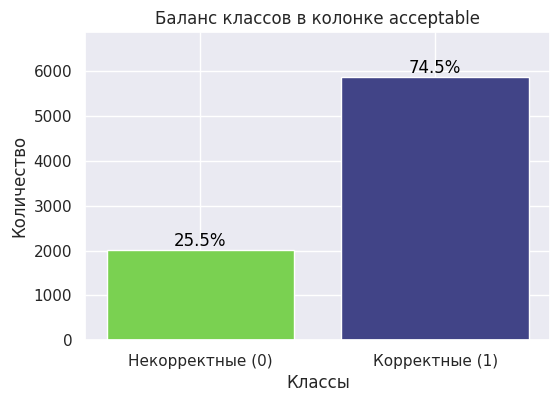

In [15]:
# Вычисление процентов
total = class_counts.sum()
percentages = (class_counts / total) * 100

# Градиентные цвета
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(class_counts)))  # Градиент от темного к светлому

# Построение графика
plt.figure(figsize=(6, 4))
bars = plt.bar(class_counts.index, class_counts.values, color=colors)

# Добавление процентов над столбцами
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5, f'{percentage:.1f}%',
             ha='center', va='bottom', fontsize=12, color='black')

# Настройка осей и заголовка
plt.xticks([0, 1], ['Некорректные (0)', 'Корректные (1)'])
plt.xlabel('Классы')
plt.ylabel('Количество')
plt.title('Баланс классов в колонке acceptable')
plt.ylim(0, max(class_counts.values) + 1000)  # Добавляем немного места для текста
plt.show()

<div style="padding: 10px; background-color: #e3f2fd; border-left: 5px solid #2196f3;">
    <i class="fa fa-info-circle" style="color: #2196f3;"></i>
    Видим, что данные не содержат ни пропусков, ни дубликатов. Однако наш датасет несбалансирован по классам, в дальнейшем учтем это при finetuning ruBert-base


**Теперь посмотрим на статистики длины предложений в текстах**

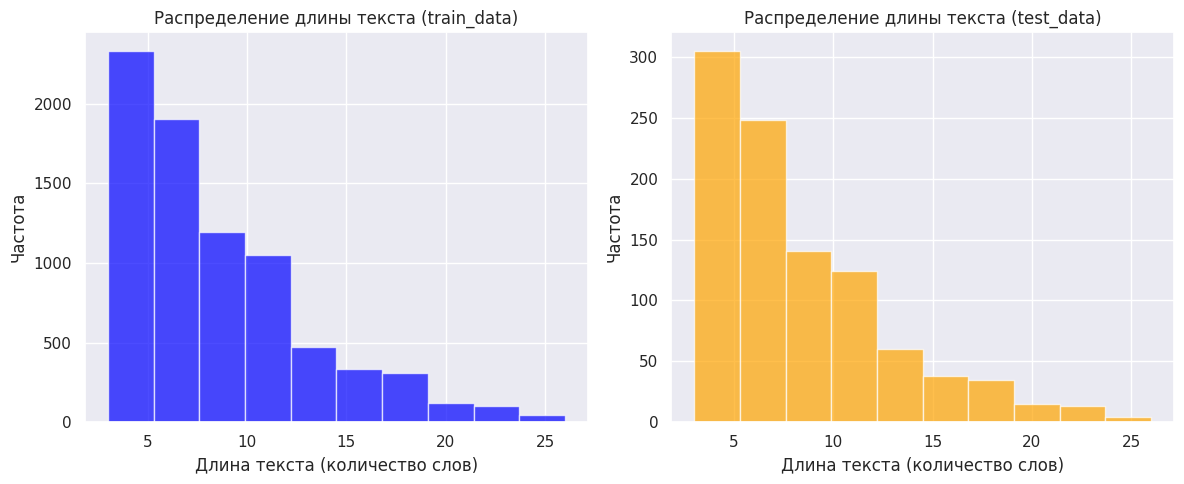

In [16]:
train_data['length_text'] = train_data.sentence.apply(lambda x: len(str(x).split()))
test_data['length_text'] = test_data.sentence.apply(lambda x: len(str(x).split()))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Гистограмма для train_data
train_data.length_text.hist(ax=axes[0], bins=10, color='blue', alpha=0.7)
axes[0].set_title('Распределение длины текста (train_data)')
axes[0].set_xlabel('Длина текста (количество слов)')
axes[0].set_ylabel('Частота')
# Гистограмма для test_data
test_data.length_text.hist(ax=axes[1], bins=10, color='orange', alpha=0.7)
axes[1].set_title('Распределение длины текста (test_data)')
axes[1].set_xlabel('Длина текста (количество слов)')
axes[1].set_ylabel('Частота')

plt.tight_layout()
plt.show()

In [15]:
train_data.length_text.describe()

count    7869.000000
mean        8.556487
std         4.472081
min         3.000000
25%         5.000000
50%         7.000000
75%        11.000000
max        26.000000
Name: length_text, dtype: float64

In [16]:
test_data.length_text.describe()

count    983.000000
mean       8.400814
std        4.413237
min        3.000000
25%        5.000000
50%        7.000000
75%       10.000000
max       26.000000
Name: length_text, dtype: float64

Посмотрим на распределение данных поближе. Выведем основные квантили в распределении тренировочных данных.

In [17]:
from scipy.stats import iqr

print(train_data.length_text.quantile(0.25)-iqr(train_data.length_text),
      train_data.length_text.quantile(0.25),
      train_data.length_text.quantile(0.5),
      train_data.length_text.quantile(0.75),
      train_data.length_text.quantile(0.75)+iqr(train_data.length_text))

-1.0 5.0 7.0 11.0 17.0


**Статистики длины предложений адекватны целевым классам**:

- минимальное количество слов - 3;
- максимальное - 26
- наиболее репрезантивная часть данных находится в диапазоне длин от 5 до 11 слов.

**Таким образом, данные готовы для обучения и не требуют предобработки**

<div style="border: 2px solid #1f77b4; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold; color: #1f77b4;">
  RuBert_base
</div>

## Fine-tuning RuBERT-base

### Загрузка токенизатора и модели

In [56]:
model_name = 'ai-forever/ruBert-base'
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=False) # гипотеза: регистр может дать нек. доп. признаки для классификации

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

In [88]:
# Get the lists of sentences and their labels.
sentences = train_data.sentence.values
labels = train_data.acceptable.values

In [89]:
sentences = test_data.sentence.values
labels = test_data.acceptable.values

In [90]:
# Print the original sentence.
print(' Original: ', sentences[1])
# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[1]))
# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[1])))

 Original:  У многих туристов, кто посещают Кемер весной, есть шанс застать снег на вершине горы Тахталы и даже сочетать пляжный отдых с горнолыжным.
Tokenized:  ['▁У', '▁многих', '▁туристов', ',', '▁кто', '▁посещают', '▁Кем', 'ер', '▁весной', ',', '▁есть', '▁шанс', '▁за', 'стать', '▁снег', '▁на', '▁вершине', '▁горы', '▁Та', 'хта', 'лы', '▁и', '▁даже', '▁сочета', 'ть', '▁пляж', 'ный', '▁отдых', '▁с', '▁горнолыж', 'ным', '.']
Token IDs:  [114, 1091, 9080, 3, 195, 30221, 15881, 435, 8495, 3, 133, 3902, 22, 9985, 3842, 9, 16635, 4176, 1388, 17438, 967, 5, 135, 6666, 123, 7046, 71, 5482, 11, 28462, 124, 4]


Найдем максимальную длину Tokenized sentence

In [24]:
max_len = 0
for sent in sentences:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)

Max sentence length:  38


### Вспомогательные функции

**Функция для вычисления целевых метрик**

In [57]:
MCC = evaluate.load("matthews_correlation", keep_in_memory=True)

In [64]:
def compute_metrics(p: EvalPrediction):
    # Получаем предсказанные классы (индекс класса с максимальной вероятностью)
    preds = np.argmax(p.predictions, axis=1)
    # Истинные метки
    labels = p.label_ids
    # Вычисляем метрики
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    mcc_result = MCC.compute(predictions=preds, references=p.label_ids)
    # Возвращаем словарь с метриками
    result = {
        "accuracy": accuracy,
        "eval_f1": f1,
        "eval_mcc": mcc_result["matthews_correlation"]}
    return result

**Функция для предобработки данных**

In [65]:
# Функция для предобработки данных
def preprocess_examples(examples, tokenizer, max_length=38):
    """
    Предобработка данных.

    :param examples: данные для обработки
    :param tokenizer: токенизатор
    :return: обработанные данные
    """
    result = tokenizer(examples["sentence"],
                       truncation=True,
                       padding="max_length",  # Дополнять последовательности до max_length
                       max_length=max_length)  # Устанавливаем максимальную длину

    if "acceptable" in examples:
        result["label"] = examples["acceptable"]  # добавление меток классов

    result["length"] = [len(list(tokenize(sentence))) for sentence in examples["sentence"]]  # сохранение длины предложений
    return result

**Функция для загрузки и разделения данных**
_____________
Данные разделим в соотношении 80%/20%

1) так как в наших данных присуствует дисбаланс по классам + этих данных совсем немного, добавим в функцию опицональный доп. параметр - upsample;

2) для сохранения пропорций классов в train_df и val_df укажем stratify.

In [67]:
def load_and_split_data(train_data, test_data, val_size=0.2, random_state=42, upsample=False):
    """
    Загрузка и разделение данных с учетом дисбаланса классов.

    :param train_data: Обучающие данные (DataFrame).
    :param test_data: Тестовые данные (DataFrame).
    :param val_size: Доля данных для валидации (по умолчанию 0.25).
    :param random_state: Seed для воспроизводимости (по умолчанию 42).
    :param upsample: Если True, выполняется апсэмплинг миноритарного класса.
    :return: train_dataset, val_dataset, test_dataset
    """
    # Разделение данных с учетом дисбаланса классов
    train_df, val_df = train_test_split(
        train_data,
        test_size=val_size,
        random_state=random_state,
        stratify=train_data["acceptable"]  # Учитываем дисбаланс классов
    )

    # Апсэмплинг миноритарного класса (если upsample=True)
    if upsample:
        majority_class = train_df[train_df['acceptable'] == 1]
        minority_class = train_df[train_df['acceptable'] == 0]

        # Апсэмплинг миноритарного класса
        minority_upsampled = resample(
            minority_class,
            replace=True,  # Разрешаем дублирование
            n_samples=len(majority_class),  # Увеличиваем до размера мажоритарного класса
            random_state=random_state
        )

        # Объединение данных
        train_df = pd.concat([majority_class, minority_upsampled])
        # Перемешивание данных после апсэмплинга
        train_df = train_df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    # Преобразование в Dataset
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)
    test_dataset = Dataset.from_pandas(test_data)

    return train_dataset, val_dataset, test_dataset

**Создадим класс `Focal Loss`, внутри которого модифицируем стандартную кросс-энтропийную функцию потерь, добавив множитель `γ` (`gamma`)**

γ — это параметр, который контролирует, насколько сильно уменьшается вес "легких" примеров.

Эффект гаммы:

Если γ = 0, Focal Loss эквивалентна стандартной кросс-энтропии.

Обычное значение при дисбалансе классов γ = 2.

При увеличении γ модель больше фокусируется на сложных примерах (тех, где вероятность, которую модель присваивает правильному классу близка к 0 для правильного класса), уменьшая вклад легких примеров (где указанная вероятность близка к 1).

In [68]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        """
        Focal Loss для борьбы с дисбалансом классов.

        :param alpha: Веса классов (тензор размерности [num_classes]).
        :param gamma: Параметр фокусировки (по умолчанию 2.0).
        :param reduction: Редукция потерь ('mean', 'sum' или 'none').
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Вычисляем кросс-энтропийные потери
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)

        # Вычисляем вероятности (softmax)
        pt = torch.exp(-ce_loss)

        # Вычисляем Focal Loss
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        # Применяем редукцию
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

**Создадим класс `CustomTrainer` для того, чтобы добавить указанные параметр `gamma`, а также `class_weights`**

In [69]:
class CustomTrainer(Trainer):
    def __init__(self, class_weights=None, gamma=3.0, *args, **kwargs):
        """
        :param class_weights: Веса классов (тензор размерности [num_classes]).
        :param gamma: Параметр фокусировки для Focal Loss (по умолчанию 2.0).
        """
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        self.gamma = gamma

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Вычисление потерь с использованием Focal Loss.

        :param model: Модель.
        :param inputs: Входные данные.
        :param return_outputs: Возвращать ли выходы модели.
        :param kwargs: Дополнительные аргументы (например, num_items_in_batch).
        :return: Потери и (опционально) выходы модели.
        """
        # Извлекаем

        labels = inputs.get("labels")

        # Получаем выходы модели
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Вычисляем Focal Loss
        if self.class_weights is not None:
            self.class_weights = self.class_weights.to(logits.device)  # Переносим веса на устройство (GPU/CPU)
            loss_fct = FocalLoss(alpha=self.class_weights, gamma=self.gamma)
        else:
            loss_fct = FocalLoss(gamma=self.gamma)

        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

Будем считать дисбаланс в данных умеренным, поэтому не будем изменять соотношение весов для логитов на выходе модели

In [70]:
class_weights = tensor([1.0, 1.0])
class_weights

tensor([1., 1.])

**Функция для визуализации прогресса обучения**

In [71]:
def plot_training_progress(trainer):
    """
    Визуализация прогресса обучения:
    - График потерь (train и val).
    - График MCC и F1 на валидации.
    """
    logs = trainer.state.log_history

    # Извлечение потерь и метрик
    train_losses = [log["loss"] for log in logs if "loss" in log]
    eval_losses = [log["eval_loss"] for log in logs if "eval_loss" in log]
    eval_mcc_scores = [log["eval_mcc"] for log in logs if "eval_mcc" in log]
    eval_f1_scores = [log["eval_f1"] for log in logs if "eval_f1" in log]

    # Построение графиков
    plt.figure(figsize=(12, 5))

    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Training Loss", color="blue")
    plt.plot(eval_losses, label="Validation Loss", color="red")
    plt.title("Training and Validation Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # График MCC и F1
    plt.subplot(1, 2, 2)
    plt.plot(eval_mcc_scores, label="Validation MCC", color="green")
    plt.plot(eval_f1_scores, label="Validation F1", color="orange")
    plt.title("Validation MCC and F1")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()

    plt.tight_layout()
    plt.show()

### Основная функция для обучения
Обучим модель с помощью `Trainer` от `Hugging Face`

Предложенный [код mlm-fine-tuning ](https://github.com/RussianNLP/RuCoLA/blob/main/baselines/finetune_mlm.py) предполагает обучение на всей тренировочной выборке, при этом оценка на валидации просиходит на выборке, которую предложено использовать в качестве тестовой. При этом тестовая выборка представлена отдельно. То есть в учебных целях преложено обучаться на датасете меньшего объема, так как данных для таких тяжелых моделей как BERT и так немного, это может повлиять на качество предсказаний редкого класса  лингвистически неприемлимых текстов. 

Также отметим, что:

1. Метрика accuracy не учитывает дисбаланс классов. Так, `DummyClassifier`(cтратегия `stratified`) будет предсказывать классы в соответствии с распределением классов в обучающих данных (75% — класс 1, 25% — класс 0), при этом accuracy будет близка к 0.75.

2. Сосредоточимся на максимизации MCC + F1, также будет отслеживать динамику `Precision` и `Recall`.

**Отмечу, что пробовал и классический fine-tuning, с "заморозкой" backbone модели + добавлением линейных слоев, с dropout, batchnorm и т.д., однако модель не смогла обучиться выявлять паттерны лингвистической приемлемости. При этом действительно значение метрики на валидации приближалось к 0.75, однако F1-score для Class 0 принимала околонулевые значения. Полагаю, "замороженные" слои model backbone остаются неадаптированными к данным, так как задача определения лингвистической приемлимости является специфичной, соответственно, полагаю, целесообразно обновлять веса всей модели.**

#### Подбор оптимальных гиперпараметров для модели (без upsampling): поиск по сетке

С учетом имеющегося дисбаланса классов,

In [72]:
# Определение параметров для Grid Search

# LR_VALUES = [1e-5, 5e-5]
# DECAY_VALUES = [1e-2, 1e-4, 0.1]
# BATCH_SIZES = [32]
# GAMMAS = [1.0]
# N_EPOCHS = 5 # количество эпох

def training_loop_grid_search(model_name, train_data, test_data, upsample=False):

    tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=False)
                    # Инициализация модели
    model = BertForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
        problem_type="single_label_classification",
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1,
    ).to(device)

    # Загрузка и разделение данных
    train_dataset, val_dataset, test_dataset = load_and_split_data(train_data, test_data, upsample=upsample)

    # Токенизация данных
    tokenized_train = train_dataset.map(
        partial(preprocess_examples, tokenizer=tokenizer),
        batched=True,
        remove_columns=["sentence"],
        keep_in_memory=True,
    )
    tokenized_val = val_dataset.map(
        partial(preprocess_examples, tokenizer=tokenizer),
        batched=True,
        remove_columns=["sentence"],
        keep_in_memory=True,
    )
    tokenized_test = test_dataset.map(
        partial(preprocess_examples, tokenizer=tokenizer),
        batched=True,
        remove_columns=["sentence"],
        keep_in_memory=True,
    )

    # Лучшие метрики
    best_mcc = -1
    best_params = {}
    best_model = None

    # Перебор всех комбинаций параметров
    for lr in LR_VALUES:
        for decay in DECAY_VALUES:
            for batch_size in BATCH_SIZES:
                for gamma in GAMMAS:
                    print(f"\nTraining with LR={lr}, Decay={decay}, Batch Size={batch_size}, Gamma={gamma}")

                    # Создание DataCollator
                    data_collator = DataCollatorWithPadding(tokenizer)
                    run_base_dir = f"{model_name}_{lr}_{decay}_{batch_size}_{gamma}"

                    # Настройка аргументов обучения
                    training_args = TrainingArguments(
                        output_dir=f"checkpoints/{run_base_dir}",
                        overwrite_output_dir=True,
                        logging_strategy="epoch",
                        evaluation_strategy="epoch",
                        per_device_train_batch_size=batch_size,
                        per_device_eval_batch_size=batch_size,
                        learning_rate=lr,
                        weight_decay=decay,
                        num_train_epochs=N_EPOCHS,
                        warmup_ratio=0.1,
                        optim="adamw_torch",
                        save_strategy="epoch",
                        save_total_limit=1,
                        seed=SEED,
                        fp16=True,
                        tf32=False,
                        dataloader_num_workers=4,
                        group_by_length=True,
                        report_to="none",  # Отключение wandb
                        load_best_model_at_end=True,
                        metric_for_best_model="eval_mcc",
                    )
                    # Инициализация Trainer
                    trainer = CustomTrainer(
                        model=model,
                        args=training_args,
                        train_dataset=tokenized_train,
                        eval_dataset=tokenized_val,
                        compute_metrics=compute_metrics,
                        tokenizer=tokenizer,
                        data_collator=data_collator,
                        gamma=gamma,
                        class_weights=class_weights,
                        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
                    )
                    # Обучение модели
                    print("Starting training...")
                    trainer.train()
                    print("Training completed.")

                    # Визуализация прогресса обучения
                    plot_training_progress(trainer)

                    # Оценка на валидации
                    print("Evaluating on validation set...")
                    val_predictions = trainer.predict(tokenized_val)
                    val_mcc = val_predictions.metrics["test_eval_mcc"]
                    print(f"Validation MCC: {val_mcc:.4f}")

                    # Сохранение лучшей модели
                    if val_mcc > best_mcc:
                        best_mcc = val_mcc
                        best_params = {
                            "lr": lr,
                            "decay": decay,
                            "batch_size": batch_size,
                            "gamma": gamma,
                        }
                        best_model = trainer.model
                        print(f"New best model found with MCC={val_mcc:.4f} and params={best_params}")

                    # Очистка чекпоинтов
                    if os.path.exists(f"checkpoints/{run_base_dir}"):
                        shutil.rmtree(f"checkpoints/{run_base_dir}")

    # Сохранение лучшей модели
    if best_model is not None:
        os.makedirs("checkpoints_best", exist_ok=True)
        best_model.save_pretrained(f"checkpoints_best/{model_name}_best")
        print(f"Best model saved with MCC={best_mcc:.4f} and params={best_params}")

        # Предсказание на тестовом датасете с лучшей моделью
        print("Evaluating on test set...")

        test_predictions = trainer.predict(tokenized_test)
        test_preds = np.argmax(test_predictions.predictions, axis=-1)

        # Извлечение истинных меток
        test_labels = tokenized_test["acceptable"]

        # Вывод classification_report и f1_score
        print("Classification Report on Test Dataset:")
        print(classification_report(test_labels, test_preds, target_names=["Class 0", "Class 1"]))

         # Расчет MCC с использованием evaluate
        mcc_result = MCC.compute(predictions=test_preds, references=test_labels)
        test_mcc = mcc_result["matthews_correlation"]
        print(f"MCC on Test Dataset: {test_mcc:.4f}")

        test_f1 = f1_score(test_labels, test_preds)
        print(f"F1 Score on Test Dataset: {test_f1:.4f}")

        test_accuracy = accuracy_score(test_labels, test_preds)
        print(f"Test Accuracy: {test_accuracy:.4f}")

        return best_model
    else:
        print("No best model found.")
        return None

**Здесь длинный вывод с поиском по сетке, скрыл его для удобства восприятия**

Map:   0%|          | 0/6295 [00:00<?, ? examples/s]

Map:   0%|          | 0/1574 [00:00<?, ? examples/s]

Map:   0%|          | 0/983 [00:00<?, ? examples/s]


Training with LR=1e-05, Decay=0.01, Batch Size=32, Gamma=1.0


pytorch_model.bin:   0%|          | 0.00/716M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


Epoch,Training Loss,Validation Loss,F1,Mcc,Accuracy
1,0.318100,0.275501,0.636137,-0.014742,0.744600
2,0.240700,0.248332,0.760649,0.396237,0.799873
3,0.176600,0.277783,0.761099,0.393534,0.799238
4,0.135200,0.298317,0.772771,0.420897,0.806226
5,0.109300,0.297626,0.783966,0.436782,0.810038


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Training completed.


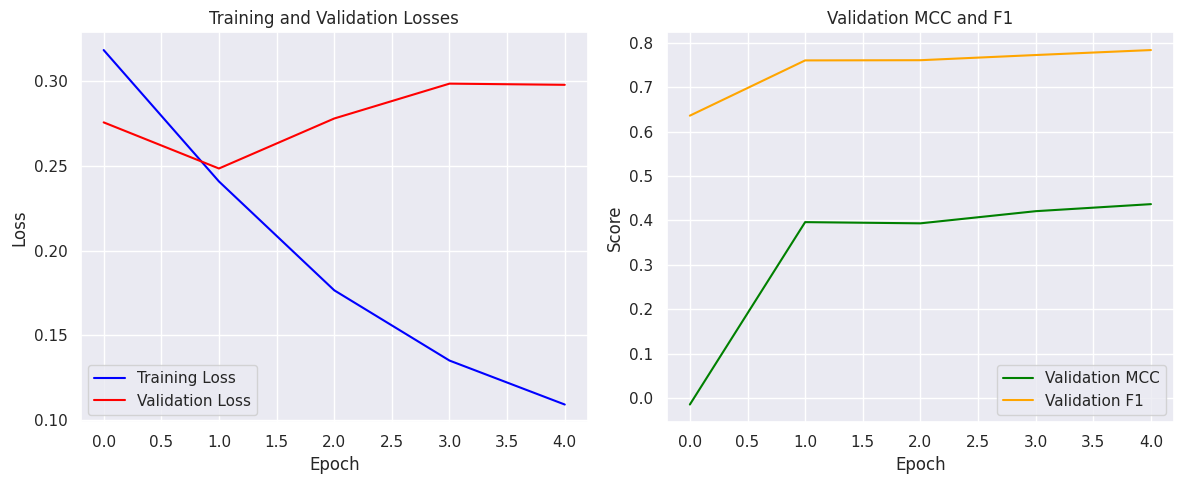

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Evaluating on validation set...


Validation MCC: 0.4368
New best model found with MCC=0.4368 and params={'lr': 1e-05, 'decay': 0.01, 'batch_size': 32, 'gamma': 1.0}

Training with LR=1e-05, Decay=0.0001, Batch Size=32, Gamma=1.0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


Epoch,Training Loss,Validation Loss,F1,Mcc,Accuracy
1,0.309600,0.277185,0.640607,0.057369,0.746506
2,0.245400,0.263832,0.717144,0.310996,0.779543
3,0.186500,0.262148,0.767482,0.408610,0.803050
4,0.144400,0.285880,0.769956,0.416055,0.804956
5,0.118100,0.283484,0.776924,0.421779,0.806226


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Training completed.


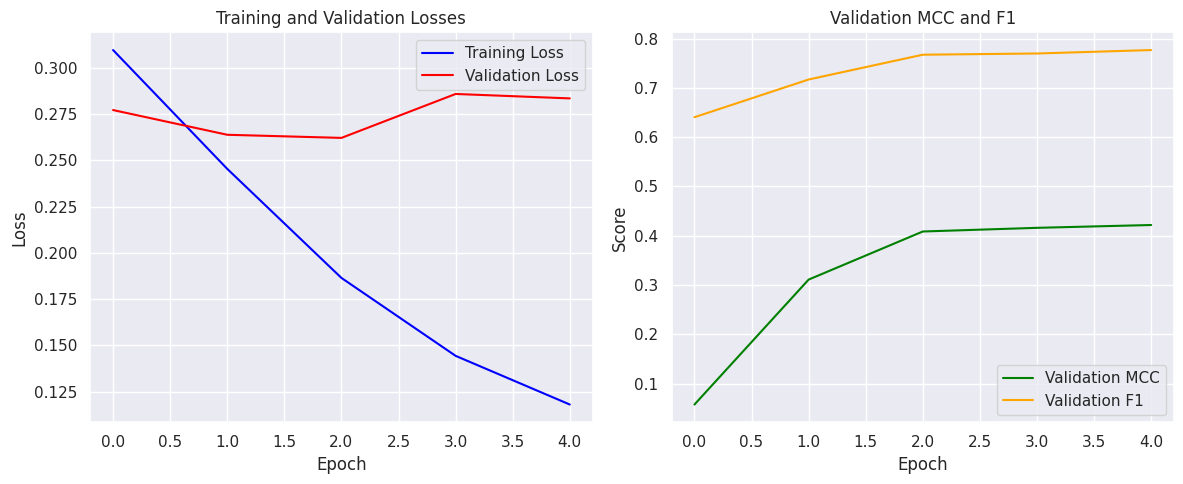

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Evaluating on validation set...


Validation MCC: 0.4218

Training with LR=1e-05, Decay=0.1, Batch Size=32, Gamma=1.0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


Epoch,Training Loss,Validation Loss,F1,Mcc,Accuracy
1,0.309600,0.277183,0.640607,0.057369,0.746506
2,0.245400,0.263821,0.717144,0.310996,0.779543
3,0.186500,0.262140,0.767482,0.408610,0.803050
4,0.144400,0.285918,0.769956,0.416055,0.804956
5,0.118100,0.283486,0.776924,0.421779,0.806226


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Training completed.


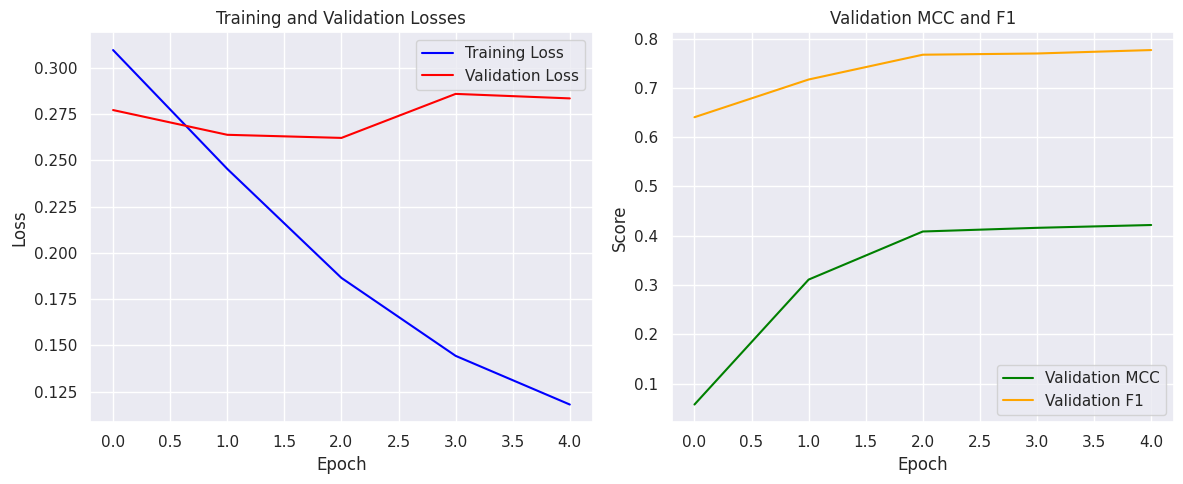

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Evaluating on validation set...


Validation MCC: 0.4218

Training with LR=5e-05, Decay=0.01, Batch Size=32, Gamma=1.0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


Epoch,Training Loss,Validation Loss,F1,Mcc,Accuracy
1,0.291400,0.238553,0.781335,0.412104,0.798602
2,0.198000,0.242555,0.796467,0.468969,0.818933
3,0.101600,0.307744,0.793231,0.445593,0.808767
4,0.046700,0.447338,0.781279,0.414984,0.801144


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Training completed.


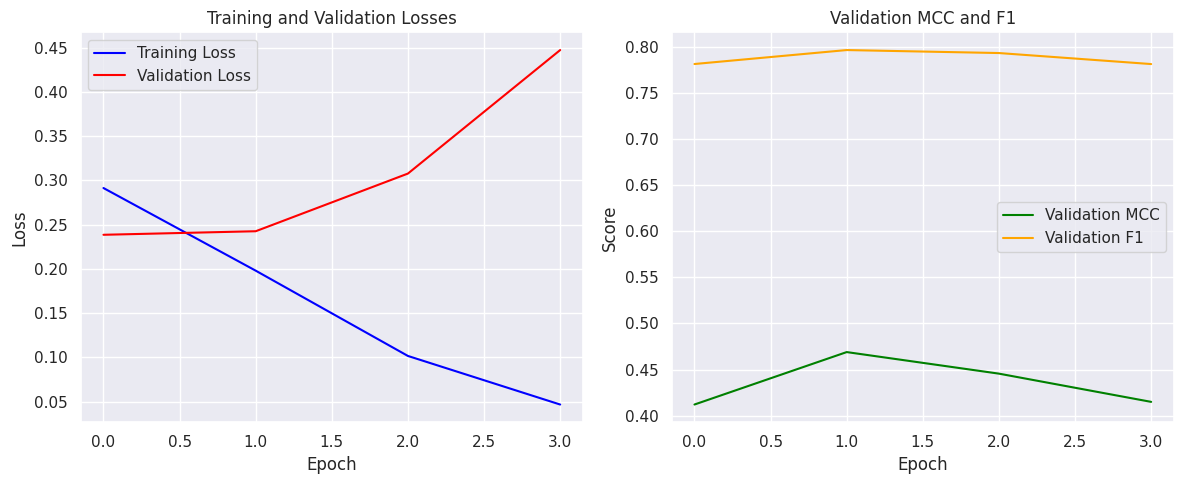

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Evaluating on validation set...


Validation MCC: 0.4690
New best model found with MCC=0.4690 and params={'lr': 5e-05, 'decay': 0.01, 'batch_size': 32, 'gamma': 1.0}

Training with LR=5e-05, Decay=0.0001, Batch Size=32, Gamma=1.0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


Epoch,Training Loss,Validation Loss,F1,Mcc,Accuracy
1,0.275100,0.235505,0.771834,0.386835,0.792249
2,0.188400,0.240406,0.804386,0.475392,0.817027
3,0.086100,0.343304,0.794162,0.452411,0.812579
4,0.045800,0.547963,0.757610,0.385858,0.797332


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Training completed.


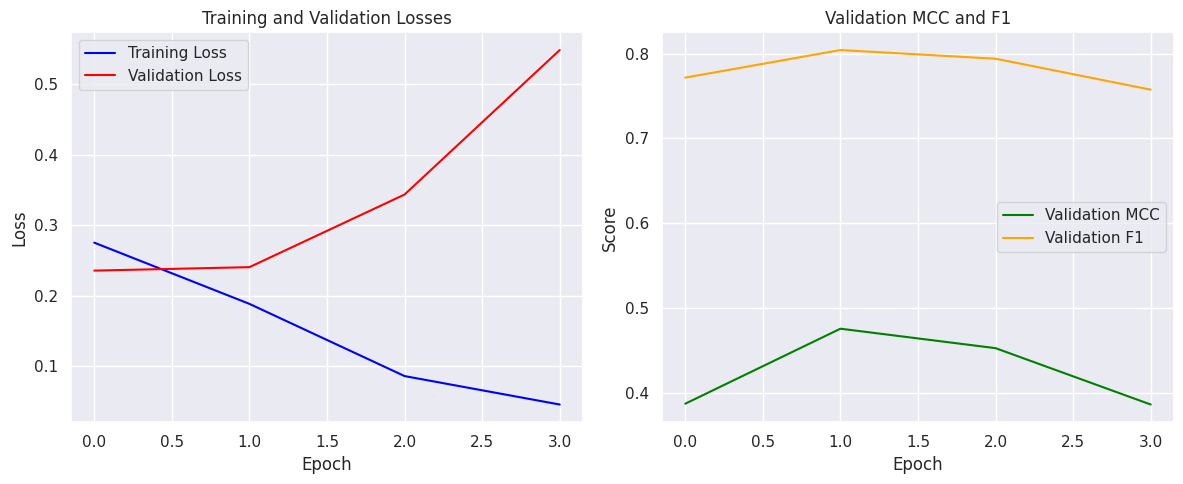

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Evaluating on validation set...


Validation MCC: 0.4754
New best model found with MCC=0.4754 and params={'lr': 5e-05, 'decay': 0.0001, 'batch_size': 32, 'gamma': 1.0}

Training with LR=5e-05, Decay=0.1, Batch Size=32, Gamma=1.0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


Epoch,Training Loss,Validation Loss,F1,Mcc,Accuracy
1,0.275100,0.235509,0.771834,0.386835,0.792249
2,0.188400,0.240380,0.804386,0.475392,0.817027
3,0.086100,0.342632,0.794162,0.452411,0.812579
4,0.045600,0.547468,0.758615,0.388435,0.797967


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Training completed.


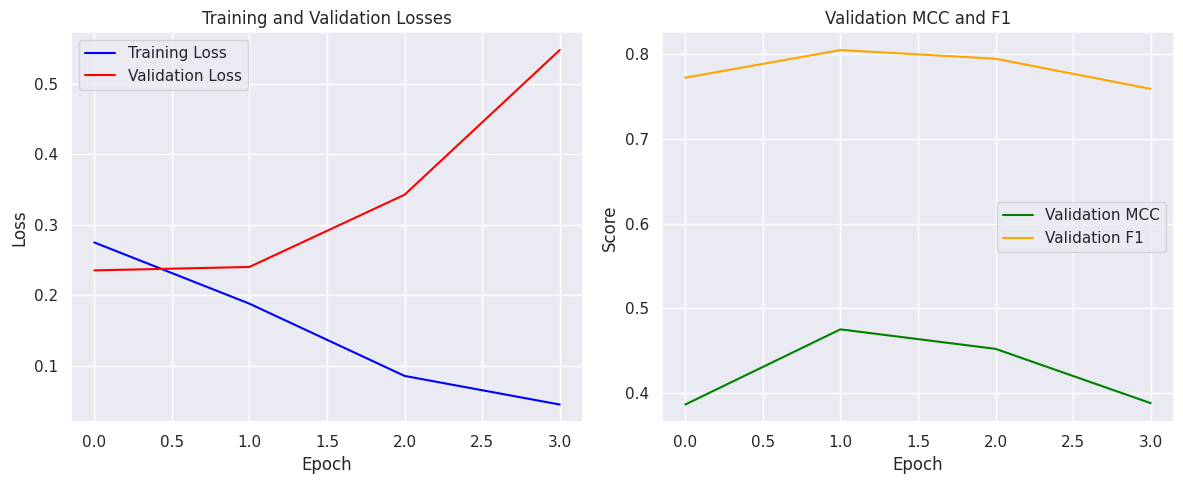

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Evaluating on validation set...


Validation MCC: 0.4754


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Best model saved with MCC=0.4754 and params={'lr': 5e-05, 'decay': 0.0001, 'batch_size': 32, 'gamma': 1.0}
Evaluating on test set...


Classification Report on Test Dataset:
              precision    recall  f1-score   support

     Class 0       0.30      0.20      0.24       250
     Class 1       0.75      0.83      0.79       733

    accuracy                           0.67       983
   macro avg       0.53      0.52      0.52       983
weighted avg       0.64      0.67      0.65       983

MCC on Test Dataset: 0.0446
F1 Score on Test Dataset: 0.7927
Test Accuracy: 0.6745


In [20]:
ruBert_base_trained_model = ruBert_base_trained_model = training_loop_grid_search('ai-forever/ruBert-base', tokenizer)

Map:   0%|          | 0/6295 [00:00<?, ? examples/s]

Map:   0%|          | 0/1574 [00:00<?, ? examples/s]

Map:   0%|          | 0/983 [00:00<?, ? examples/s]


Training with LR=3e-05, Decay=0.0001, Batch Size=32, Gamma=0.5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


Epoch,Training Loss,Validation Loss,F1,Mcc,Accuracy
1,0.397500,0.342341,0.730803,0.293048,0.774460
2,0.305600,0.348669,0.765729,0.414511,0.804320
3,0.166600,0.423557,0.774362,0.418791,0.805591
4,0.089500,0.506454,0.779171,0.426740,0.807497
5,0.057300,0.550698,0.796083,0.450853,0.806861
6,0.034100,0.772388,0.789524,0.449066,0.813215
7,0.021000,0.821611,0.795857,0.456914,0.813850


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

Training completed.


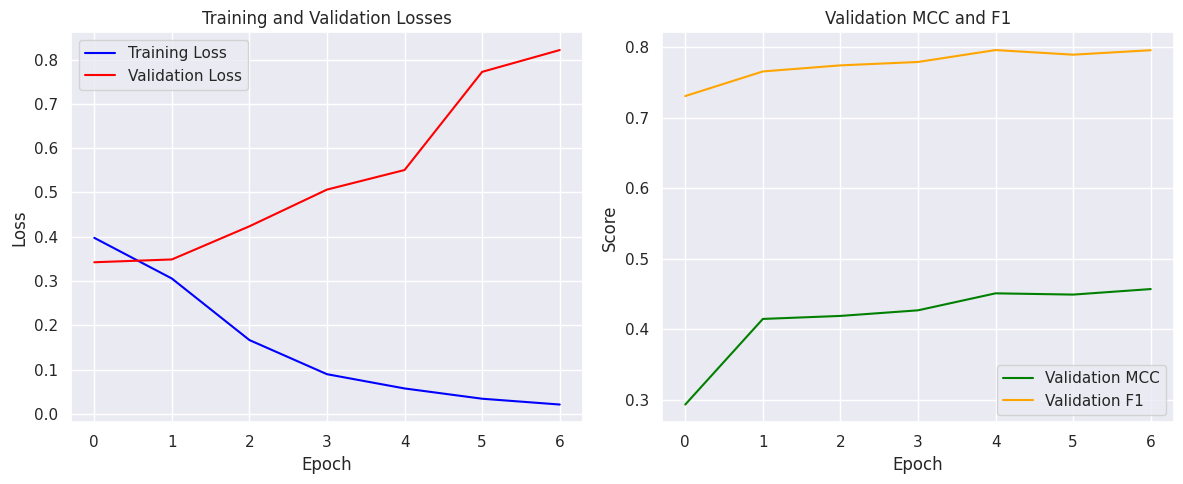

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Evaluating on validation set...


Validation MCC: 0.4569
New best model found with MCC=0.4569 and params={'lr': 3e-05, 'decay': 0.0001, 'batch_size': 32, 'gamma': 0.5}


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Best model saved with MCC=0.4569 and params={'lr': 3e-05, 'decay': 0.0001, 'batch_size': 32, 'gamma': 0.5}
Evaluating on test set...


Classification Report on Test Dataset:
              precision    recall  f1-score   support

     Class 0       0.32      0.19      0.24       250
     Class 1       0.76      0.86      0.81       733

    accuracy                           0.69       983
   macro avg       0.54      0.53      0.52       983
weighted avg       0.65      0.69      0.66       983

MCC on Test Dataset: 0.0611
F1 Score on Test Dataset: 0.8061
Test Accuracy: 0.6907


In [42]:
ruBert_base_trained_model = training_loop_grid_search('ai-forever/ruBert-base', tokenizer)

**Итог**

1. **Best model** saved with MCC=0.4569 and params={'lr': 3e-05, 'decay': 0.0001, 'batch_size': 32, 'gamma': 0.5}.

2. **Метрики лучшей модели** (*с учетом дисбаланса, метрика на которой оценивалось качество - F1*):

`Class 0` (неприемлемые тексты):

*   Precision: 0.32
*   Recall: 0.19
*   F1-score: 0.24

Class 1 (приемлемые тексты):

*   Precision: 0.76
*   Recall: 0.86
*   F1-score: 0.81

---

•	Accuracy: 0.69
•	F1 Score (средний): 0.81
•	MCC Score (средний): 0.06

---

**Интерпретация метрик**:

1. Низкие значения precision, recall и F1-score для `Class 0` указывают на то, что модель плохо справляется с определением неприемлемых текстов.

2. При этом, при обучении без параметра `gamma` в функции потерь качество модели приблажается к `DummyClassifier`, метрики для `Class 0` стремятся к 0.

3. **Возможные причины низкого качества для `Class 0`**:

- Помимо дисбаланса классов это может быть связано с **недостаточной репрезентативностью данных** для этого класса: задача лингвистической приемлемости может быть сложной (например, если ошибки представляют собой так называемые "галлюцинации", признаки которых могут быть сложно различимы и вариативны), особенно если неприемлемые тексты имеют тонкие различия с приемлемыми. Это требует более качественных и разнообразных данных для обучения;

- Возможно, данные для `Class 0` недостаточно разнообразны, модель может не научиться корректно их классифицировать, ЛИБО данные кластеризуются по нескольким группам, признаки которых имеют небольшой песекающийся объем: например, "галлюцинации" и морфологические ошибки.

- **Недостаточный объем данных для обучения модели**: Rubert-base — так или иначе, мощная модель, но она может быть избыточной для задачи с небольшим объемом данных. Графики прогресса обучения подтверждают это: начиная с 3й эпохи, модель, очевидно, переобучается.


#### Модель, обученная на upsampled data

In [75]:
LR_VALUES = [3e-5]
DECAY_VALUES = [1e-4]
BATCH_SIZES = [32, 64]
GAMMAS = [0.5]
N_EPOCHS = 7 # количество эпох

Map:   0%|          | 0/9382 [00:00<?, ? examples/s]

Map:   0%|          | 0/1574 [00:00<?, ? examples/s]

Map:   0%|          | 0/983 [00:00<?, ? examples/s]


Training with LR=3e-05, Decay=0.0001, Batch Size=32, Gamma=0.5
Starting training...
{'loss': 0.426, 'grad_norm': 297188.53125, 'learning_rate': 2.8574514038876892e-05, 'epoch': 1.0}
{'eval_f1': 0.7773205719275119, 'eval_mcc': 0.4030585451616097, 'eval_loss': 0.3378729522228241, 'eval_accuracy': 0.7827191867852605, 'eval_runtime': 3.4735, 'eval_samples_per_second': 453.15, 'eval_steps_per_second': 7.197, 'epoch': 1.0}
{'loss': 0.2032, 'grad_norm': 445539.3125, 'learning_rate': 2.3812095032397406e-05, 'epoch': 2.0}
{'eval_f1': 0.8013864623041083, 'eval_mcc': 0.4706884728651451, 'eval_loss': 0.37785759568214417, 'eval_accuracy': 0.8043202033036849, 'eval_runtime': 4.0203, 'eval_samples_per_second': 391.513, 'eval_steps_per_second': 6.218, 'epoch': 2.0}
{'loss': 0.0958, 'grad_norm': 275349.21875, 'learning_rate': 1.9049676025917927e-05, 'epoch': 3.0}
{'eval_f1': 0.8030825424587915, 'eval_mcc': 0.4702331915759929, 'eval_loss': 0.46653783321380615, 'eval_accuracy': 0.8119440914866582, 'eval

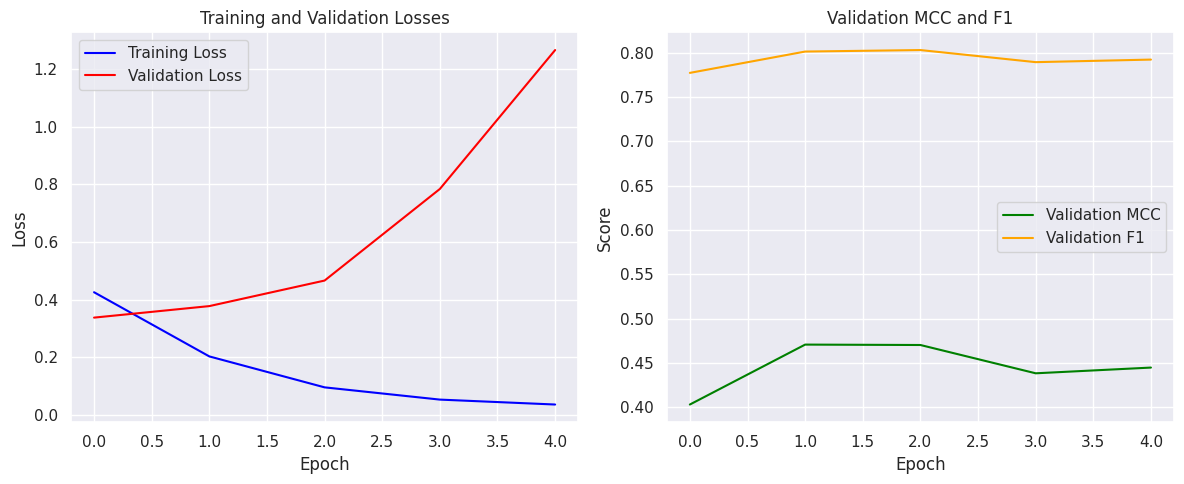

Evaluating on validation set...
Validation MCC: 0.4707
New best model found with MCC=0.4707 and params={'lr': 3e-05, 'decay': 0.0001, 'batch_size': 32, 'gamma': 0.5}

Training with LR=3e-05, Decay=0.0001, Batch Size=64, Gamma=0.5
Starting training...
{'loss': 0.0784, 'grad_norm': 625291.375, 'learning_rate': 2.8583690987124466e-05, 'epoch': 1.0}
{'eval_f1': 0.7899164380207643, 'eval_mcc': 0.44481065225658595, 'eval_loss': 0.6179983019828796, 'eval_accuracy': 0.8113087674714105, 'eval_runtime': 2.8856, 'eval_samples_per_second': 545.46, 'eval_steps_per_second': 4.505, 'epoch': 1.0}
{'loss': 0.0653, 'grad_norm': 475827.0, 'learning_rate': 2.3819742489270384e-05, 'epoch': 2.0}
{'eval_f1': 0.7877472928467952, 'eval_mcc': 0.43711380571041214, 'eval_loss': 0.6102762818336487, 'eval_accuracy': 0.8087674714104193, 'eval_runtime': 2.9324, 'eval_samples_per_second': 536.757, 'eval_steps_per_second': 4.433, 'epoch': 2.0}
{'loss': 0.0396, 'grad_norm': 317083.21875, 'learning_rate': 1.9055793991416

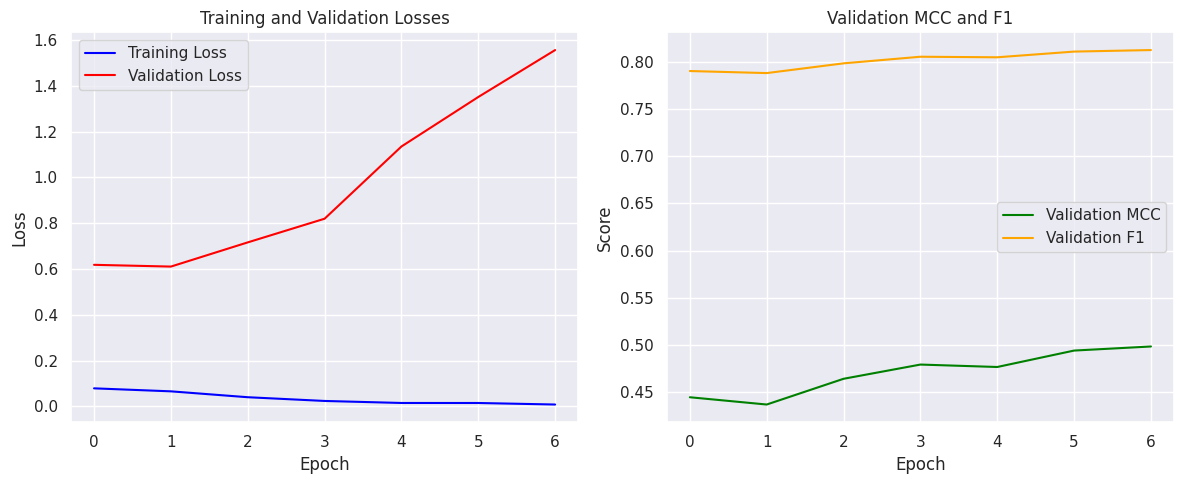

Evaluating on validation set...
Validation MCC: 0.4985
New best model found with MCC=0.4985 and params={'lr': 3e-05, 'decay': 0.0001, 'batch_size': 64, 'gamma': 0.5}
Best model saved with MCC=0.4985 and params={'lr': 3e-05, 'decay': 0.0001, 'batch_size': 64, 'gamma': 0.5}
Evaluating on test set...
Classification Report on Test Dataset:
              precision    recall  f1-score   support

     Class 0       0.24      0.14      0.18       250
     Class 1       0.74      0.85      0.79       733

    accuracy                           0.67       983
   macro avg       0.49      0.49      0.48       983
weighted avg       0.61      0.67      0.63       983

MCC on Test Dataset: -0.0172
F1 Score on Test Dataset: 0.7908
Test Accuracy: 0.6663


In [76]:
ruBert_base_trained_model_upsampled = training_loop_grid_search('ai-forever/ruBert-base', train_data, test_data, upsample=True)

 **Видим, что после апсэмплинга качество модели только ухудшилось**:

 Модель, скорее всего, "запомнила" дублированные примеры вместо того, чтобы получить обобщающую способность.

**Понятны пути улучшения качества решения задачи:**

 1) *аугментация данных для редкого класса*:
- замена слов в предложениях на их синонимы;
- перестановка слов в предложениях а-ля парафразы;
- генерацию новых примеров с помощью языковых моделей;

2) *увеличение количества примеров для редкого класса*

3) *выбор другой модели для решения задачи*

---

**Все это за пределами данной учебной задачи**

<div style="border: 2px solid #800080; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold; color: #800080;">
  RuT5_base
</div>

## Fine-tuning RuT5-base

In [77]:
from transformers import (
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    T5Tokenizer,
    T5ForConditionalGeneration,
)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [85]:
model_name = 'ai-forever/ruT5-base'
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

In [86]:
tokenizer = T5Tokenizer.from_pretrained(model_name)

In [91]:
# Print the original sentence.
print(' Original: ', sentences[1])
# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[1]))
# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[1])))

 Original:  У многих туристов, кто посещают Кемер весной, есть шанс застать снег на вершине горы Тахталы и даже сочетать пляжный отдых с горнолыжным.
Tokenized:  ['▁У', '▁многих', '▁туристов', ',', '▁кто', '▁посещают', '▁Кем', 'ер', '▁весной', ',', '▁есть', '▁шанс', '▁за', 'стать', '▁снег', '▁на', '▁вершине', '▁горы', '▁Та', 'хта', 'лы', '▁и', '▁даже', '▁сочета', 'ть', '▁пляж', 'ный', '▁отдых', '▁с', '▁горнолыж', 'ным', '.']
Token IDs:  [114, 1091, 9080, 3, 195, 30221, 15881, 435, 8495, 3, 133, 3902, 22, 9985, 3842, 9, 16635, 4176, 1388, 17438, 967, 5, 135, 6666, 123, 7046, 71, 5482, 11, 28462, 124, 4]


In [92]:
max_len = 0
for sent in sentences:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)

Max sentence length:  43


Видим, что **токенизация для T5, которая представляет собой SeqtoSeq model, отличатеся от классического `BertTokenizer`**. Словарь увеличился (макс длина текста после токенизации ранее составляла 38). T5Tokenizer использует алгоритм SentencePiece (BERT - WordPiece), который разбивает слова более "агрессивно", иногда - как кастомный стеммер. 

In [163]:
def generate(text, max_length=10, num_beams=3, temperature=1.0, top_k=50, top_p=0.5, **kwargs):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        hypotheses = model.generate(
            **inputs,
            max_length=max_length,
            num_beams=num_beams,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            early_stopping=True,  # Остановка при EOS
            **kwargs
        )
    return tokenizer.decode(hypotheses[0], skip_special_tokens=True)

In [141]:
text = "Текст: Кошка убегает от <extra_id_0>"
generate(text)  

'хозяина.'

In [145]:
text = "Текст: Кошки убегать хозяин. Это неправильное <extra_id_0>"
generate(text)  

'поведение.'

In [179]:
text = "Текст: Кошки убегать хозяин. Это грамматически <extra_id_0>"
generate(text, num_beams=3, temperature=1.0, top_k=5, top_p=0.5)

'верно.'

In [170]:
text = "перефразируй | Лесные запахи набегали волнами; в них смешалось дыхание можжевельника, вереска, брусники."
generate(text, num_beams=3, temperature=1.0, top_k=5, top_p=0.9)  

', берёзника, бруснич'

Видим, что модель ruT5 сходу весьма "вольно" заполняет служебный токен-маску <extra_id_0>, недостаточно улавливает контекст. Видимо, это связано с тем, что в своих примерах довольно вольно его использовал). Возможности перефразирования и суммаризации - задачи, выполнению которых обучалась модель, позволяют использовать ее для нашей задачи: SEQ -> yes | no.

In [19]:
POS_LABEL = "yes"
NEG_LABEL = "no"

### Вспомогательные функции

In [20]:
from evaluate import load
ACCURACY = load("accuracy")
MCC = load("matthews_correlation")

In [21]:
def load_and_split_data(train_data, test_data, val_size=0.2, random_state=54):
    """
    Загрузка и разделение данных с учетом дисбаланса классов.

    :param train_data: Обучающие данные (DataFrame).
    :param test_data: Тестовые данные (DataFrame).
    :param val_size: Доля данных для валидации (по умолчанию 0.2).
    :param random_state: Seed для воспроизводимости (по умолчанию 42).
    :return: train_dataset, val_dataset, test_dataset
    """
    # Разделение данных с учетом дисбаланса классов
    train_df, val_df = train_test_split(
        train_data,
        test_size=val_size,
        random_state=random_state,
        stratify=train_data["acceptable"]  # Учитываем дисбаланс классов
    )

    # Преобразование в Dataset
    train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
    val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))
    test_dataset = Dataset.from_pandas(test_data.reset_index(drop=True))

    return train_dataset, val_dataset, test_dataset

In [23]:
def compute_metrics(p, tokenizer):
    """Вычисление метрик с учетом обработки тестовых данных через пустые строки"""
    # Декодируем предсказания модели
    string_preds = tokenizer.batch_decode(p.predictions, skip_special_tokens=True)
    int_preds = [1 if pred == POS_LABEL else 0 for pred in string_preds]

    # Обрабатываем истинные метки (пустые строки для теста → 0)
    labels = np.where(p.label_ids != -100, p.label_ids, tokenizer.pad_token_id)
    string_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    int_labels = []
    for label in string_labels:
        if label == POS_LABEL:
            int_labels.append(1)
        elif label == NEG_LABEL or label == "":  # Пустая строка → класс 0
            int_labels.append(0)
        else:
            raise ValueError()
    
    acc_result = ACCURACY.compute(predictions=int_preds, references=int_labels)
    mcc_result = MCC.compute(predictions=int_preds, references=int_labels)
    f1_result = f1_score(int_labels, int_preds, average="binary")

    result = {"accuracy": acc_result["accuracy"], "f1": f1_result, "mcc": mcc_result["matthews_correlation"]}

    return result

In [ ]:
def preprocess_examples(examples, tokenizer, is_test=False):
    """Обработка данных с учетом тестовой выборки, содержащей acceptable"""
    result = tokenizer(examples["sentence"], padding=False)
    if not is_test:
        # Для обучающих/валидационных данных
        label_sequences = []
        for label in examples["acceptable"]:
            if label == 1:
                target_sequence = POS_LABEL
            elif label == 0:
                target_sequence = NEG_LABEL
            else:
                raise ValueError()
            label_sequences.append(target_sequence)
    else:
        # Для тестовой выборки (даже если есть acceptable)
        # label_sequences = ["" for _ in examples["sentence"]]
        label_sequences = [tokenizer.pad_token] * len(examples["sentence"])
    
    result["labels"] = tokenizer(label_sequences, padding=False)["input_ids"]
    result["length"] = [len(list(tokenize(sentence))) for sentence in examples["sentence"]]
    
    return result

In [28]:
def plot_training_progress(trainer):
    """
    Визуализация прогресса обучения:
    - График потерь (train и val).
    - График MCC и F1 на валидации.
    """
    logs = trainer.state.log_history

    # Извлечение потерь и метрик
    train_losses = [log["loss"] for log in logs if "loss" in log]
    eval_losses = [log["eval_loss"] for log in logs if "eval_loss" in log]
    eval_mcc_scores = [log["eval_mcc"] for log in logs if "eval_mcc" in log]
    eval_f1_scores = [log["eval_f1"] for log in logs if "eval_f1" in log]

    # Построение графиков
    plt.figure(figsize=(12, 5))

    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Training Loss", color="blue")
    plt.plot(eval_losses, label="Validation Loss", color="red")
    plt.title("Training and Validation Losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # График MCC и F1
    plt.subplot(1, 2, 2)
    plt.plot(eval_mcc_scores, label="Validation MCC", color="green")
    plt.plot(eval_f1_scores, label="Validation F1", color="orange")
    plt.title("Validation MCC and F1")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()

    plt.tight_layout()
    plt.show()

### Основная функция для обучения модели

In [55]:
def training_loop_grid_search_Ru_T5(model_name, train_data, test_data):
    """
    Полный цикл обучения T5 с grid search и оценкой качества
    
    Параметры:
        model_name: название модели (например, "sberbank-ai/ruT5-base")
        train_data: DataFrame с обучающими данными
        test_data: DataFrame с тестовыми данными
    """
    # Инициализация
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)
    
    train_ds, val_ds, test_ds = load_and_split_data(train_data, test_data)
    
    # Токенизация
    tokenized_train = train_ds.map(
        partial(preprocess_examples, tokenizer=tokenizer, is_test=False),
        batched=True,
        remove_columns=["sentence", "acceptable"],
        keep_in_memory=True
    )
    tokenized_val = val_ds.map(
        partial(preprocess_examples, tokenizer=tokenizer, is_test=False),
        batched=True,
        remove_columns=["sentence", "acceptable"],
        keep_in_memory=True
    )
    tokenized_test = test_ds.map(
        partial(preprocess_examples, tokenizer=tokenizer, is_test=True),
        batched=True,
        remove_columns=["sentence", "acceptable"],
        keep_in_memory=True
    )
    
   # Коллатор
    data_collator = DataCollatorForSeq2Seq(
        tokenizer,
        pad_to_multiple_of=8,
        padding=True
    )

    # Лучшие метрики
    # Лучшие метрики
    best_mcc = -1
    best_params = {}
    best_model = None

    # Grid search
    for lr in LR_VALUES:
        for decay in DECAY_VALUES:
            for batch_size in BATCH_SIZES:
                print(f"\nTraining with LR={lr}, Decay={decay}, Batch Size={batch_size}")
                
                # model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)
                run_base_dir = f"{model_name}_{lr}_{decay}_{batch_size}"
                
                training_args = Seq2SeqTrainingArguments(
                    output_dir=f"checkpoints/{run_base_dir}",
                    overwrite_output_dir=True,
                    logging_strategy="epoch",
                    evaluation_strategy="epoch",
                    per_device_train_batch_size=batch_size,
                    per_device_eval_batch_size=batch_size,
                    learning_rate=lr,
                    weight_decay=decay,
                    num_train_epochs=N_EPOCHS,
                    lr_scheduler_type="cosine",
                    warmup_ratio=0.1,
                    optim="adamw_torch",
                    save_strategy="epoch",
                    save_total_limit=1,
                    seed=SEED,
                    fp16=True,
                    dataloader_num_workers=4,
                    group_by_length=True,
                    report_to="none",
                    load_best_model_at_end=True,
                    metric_for_best_model="eval_mcc",
                    predict_with_generate=True,
                    generation_max_length=10,    # Достаточно для "yes"/"no"

                )          
                trainer = Seq2SeqTrainer(
                    model=model,
                    args=training_args,
                    train_dataset=tokenized_train,
                    eval_dataset=tokenized_val,
                    compute_metrics=partial(compute_metrics, tokenizer=tokenizer),
                    tokenizer=tokenizer,
                    data_collator=data_collator,
                )  
                # Обучение
                print("Starting training...")
                trainer.train()
                print("Training completed.")
                
                # Визуализация прогресса
                plot_training_progress(trainer)

                # Оценка на валидации
                # Оценка на валидации
                print("Evaluating on validation set...")
                val_results = trainer.predict(tokenized_val)
                val_mcc = val_results.metrics["test_mcc"]
                print(f"Validation MCC: {val_mcc:.4f}")
                # Сохранение лучшей модели
                if val_mcc > best_mcc:
                    best_mcc = val_mcc
                    best_params = {
                        "lr": lr,
                        "decay": decay,
                        "batch_size": batch_size
                    }
                    best_model = trainer.model
                    print(f"New best model found with MCC={val_mcc:.4f} and params={best_params}")

                # Очистка чекпоинтов
                if os.path.exists(f"checkpoints/{run_base_dir}"):
                    shutil.rmtree(f"checkpoints/{run_base_dir}")

    # Финалная оценка на тесте
    if best_model is not None:
        os.makedirs("checkpoints_best", exist_ok=True)
        best_model.save_pretrained(f"checkpoints_best/{model_name}_best")
        print(f"Best model saved with MCC={best_mcc:.4f} and params={best_params}") 
        
        print("\n=== Final Test Evaluation ===")
        # Используем лучшую модель для предсказаний
        trainer.model = best_model
        test_results = trainer.predict(tokenized_test)
        # Декодирование с защитой
        pred_ids = np.clip(test_results.predictions, 0, tokenizer.vocab_size - 1)
        y_pred = [
            1 if p == POS_LABEL else 0 
            for p in tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
        ]
        y_true = test_data["acceptable"].values
        # Гарантируем совпадение размеров
        assert len(y_true) == len(y_pred), "Несоответствие размеров предсказаний и меток"    
        # Вывод результатов
        print(classification_report(y_true, y_pred, target_names=["Class 0", "Class 1"]))
        print(f"\nTest MCC: {matthews_corrcoef(y_true, y_pred):.4f}")
        print(f"Test F1: {f1_score(y_true, y_pred, average='binary'):.4f}")
        print(f"Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")
        
        return best_model
    else:
        raise RuntimeError("No best model found")

In [53]:
import warnings
from transformers.utils import logging

# Комбинированное подавление
warnings.filterwarnings("ignore", category=FutureWarning)
logging.set_verbosity_error()  # Только ошибки

Map:   0%|          | 0/6295 [00:00<?, ? examples/s]

Map:   0%|          | 0/1574 [00:00<?, ? examples/s]

Map:   0%|          | 0/983 [00:00<?, ? examples/s]


Training with LR=0.0001, Decay=0, Batch Size=128
Starting training...
{'loss': 4.9426, 'grad_norm': 419559.21875, 'learning_rate': 0.0001, 'epoch': 1.0}
{'eval_loss': 0.22077317535877228, 'eval_accuracy': 0.7452350698856417, 'eval_f1': 0.854022570076447, 'eval_mcc': 0.0, 'eval_runtime': 14.4988, 'eval_samples_per_second': 108.561, 'eval_steps_per_second': 0.483, 'epoch': 1.0}
{'loss': 0.295, 'grad_norm': 93338.875, 'learning_rate': 9.698463103929542e-05, 'epoch': 2.0}
{'eval_loss': 0.20024846494197845, 'eval_accuracy': 0.7452350698856417, 'eval_f1': 0.854022570076447, 'eval_mcc': 0.0, 'eval_runtime': 14.3281, 'eval_samples_per_second': 109.854, 'eval_steps_per_second': 0.489, 'epoch': 2.0}
{'loss': 0.2257, 'grad_norm': 26223.083984375, 'learning_rate': 8.83022221559489e-05, 'epoch': 3.0}
{'eval_loss': 0.19411079585552216, 'eval_accuracy': 0.7503176620076238, 'eval_f1': 0.8525328330206379, 'eval_mcc': 0.15818902955326736, 'eval_runtime': 15.1771, 'eval_samples_per_second': 103.709, 'ev

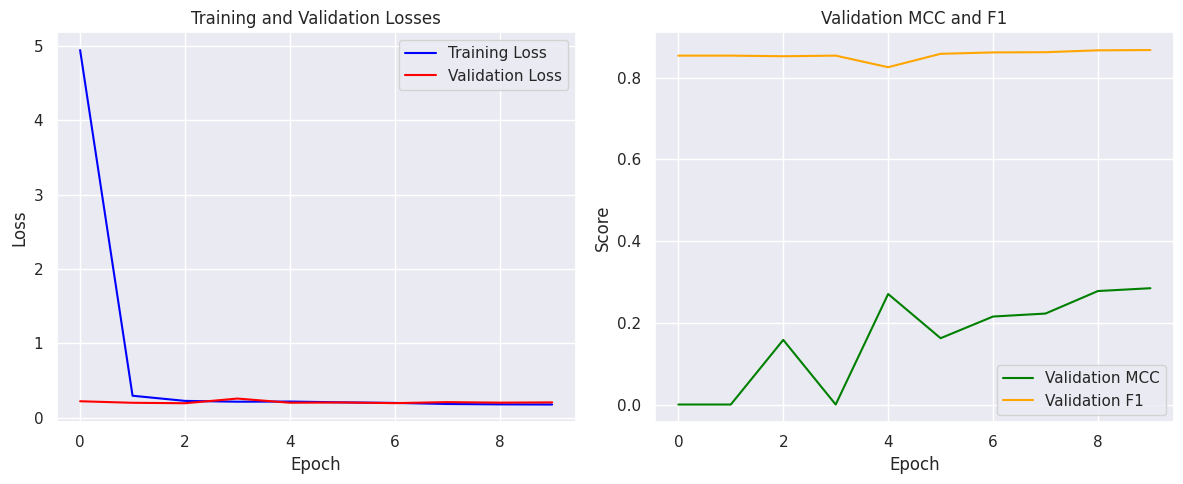

Evaluating on validation set...
Validation MCC: 0.2847
New best model found with MCC=0.2847 and params={'lr': 0.0001, 'decay': 0, 'batch_size': 128}

Training with LR=0.0001, Decay=0.0001, Batch Size=128
Starting training...
{'loss': 0.1766, 'grad_norm': 42935.0390625, 'learning_rate': 0.0001, 'epoch': 1.0}
{'eval_loss': 0.17740347981452942, 'eval_accuracy': 0.7820838627700127, 'eval_f1': 0.8712945590994372, 'eval_mcc': 0.32222239924128965, 'eval_runtime': 14.4415, 'eval_samples_per_second': 108.991, 'eval_steps_per_second': 0.485, 'epoch': 1.0}
{'loss': 0.1653, 'grad_norm': 41192.30078125, 'learning_rate': 9.698463103929542e-05, 'epoch': 2.0}
{'eval_loss': 0.22813013195991516, 'eval_accuracy': 0.7623888182973316, 'eval_f1': 0.8622974963181149, 'eval_mcc': 0.22143652347420703, 'eval_runtime': 15.7704, 'eval_samples_per_second': 99.807, 'eval_steps_per_second': 0.444, 'epoch': 2.0}
{'loss': 0.169, 'grad_norm': 51896.33984375, 'learning_rate': 8.83022221559489e-05, 'epoch': 3.0}
{'eval_l

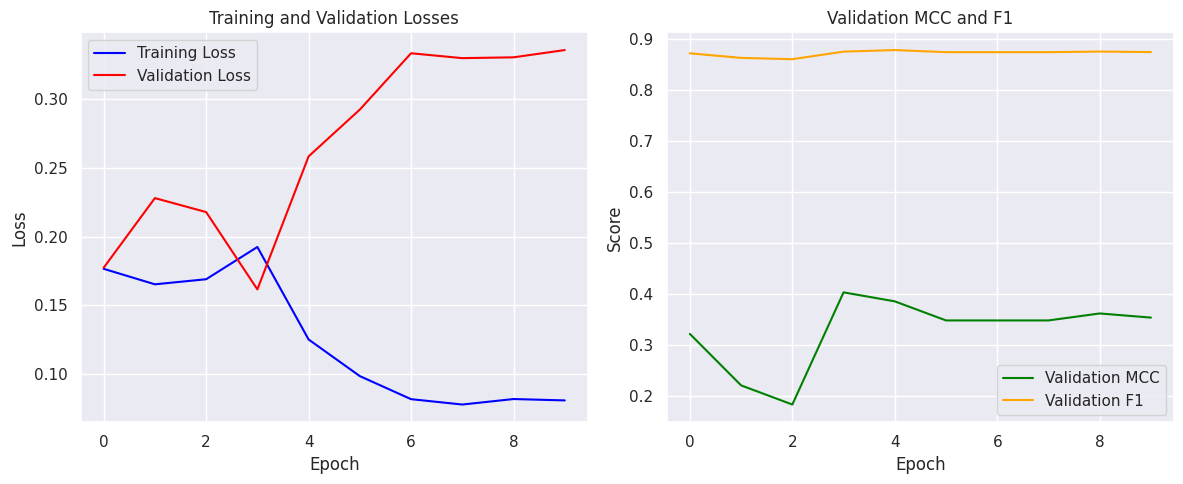

Evaluating on validation set...
Validation MCC: 0.4035
New best model found with MCC=0.4035 and params={'lr': 0.0001, 'decay': 0.0001, 'batch_size': 128}

Training with LR=0.001, Decay=0, Batch Size=128
Starting training...
{'loss': 0.1903, 'grad_norm': 573712.875, 'learning_rate': 0.001, 'epoch': 1.0}
{'eval_loss': 0.2026669681072235, 'eval_accuracy': 0.7750952986022872, 'eval_f1': 0.8681073025335321, 'eval_mcc': 0.28972526288217965, 'eval_runtime': 14.0728, 'eval_samples_per_second': 111.847, 'eval_steps_per_second': 0.497, 'epoch': 1.0}
{'loss': 0.2978, 'grad_norm': 16301.3017578125, 'learning_rate': 0.0009698463103929542, 'epoch': 2.0}
{'eval_loss': 0.24988047778606415, 'eval_accuracy': 0.7452350698856417, 'eval_f1': 0.854022570076447, 'eval_mcc': 0.0, 'eval_runtime': 15.8216, 'eval_samples_per_second': 99.484, 'eval_steps_per_second': 0.442, 'epoch': 2.0}
{'loss': 0.2315, 'grad_norm': 32050.216796875, 'learning_rate': 0.000883022221559489, 'epoch': 3.0}
{'eval_loss': 0.19401259720

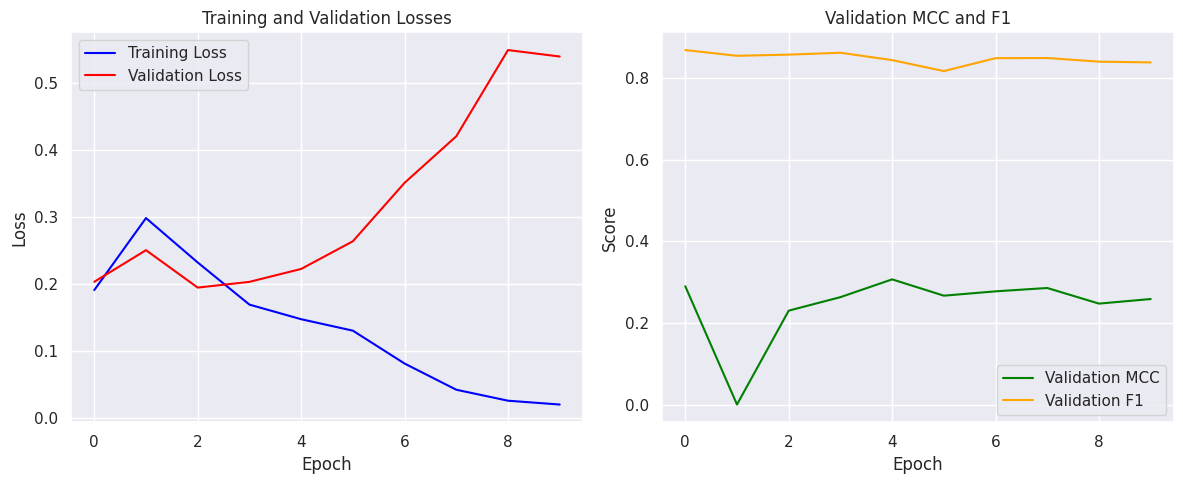

Evaluating on validation set...
Validation MCC: 0.3065

Training with LR=0.001, Decay=0.0001, Batch Size=128
Starting training...
{'loss': 0.1345, 'grad_norm': 24754.896484375, 'learning_rate': 0.001, 'epoch': 1.0}
{'eval_loss': 0.25893181562423706, 'eval_accuracy': 0.7515883100381194, 'eval_f1': 0.8432865731462926, 'eval_mcc': 0.2656067107043273, 'eval_runtime': 14.8642, 'eval_samples_per_second': 105.892, 'eval_steps_per_second': 0.471, 'epoch': 1.0}
{'loss': 0.1027, 'grad_norm': 43544.78515625, 'learning_rate': 0.0009698463103929542, 'epoch': 2.0}
{'eval_loss': 0.363627165555954, 'eval_accuracy': 0.7013977128335451, 'eval_f1': 0.7993168232280102, 'eval_mcc': 0.21620172628347484, 'eval_runtime': 14.7084, 'eval_samples_per_second': 107.014, 'eval_steps_per_second': 0.476, 'epoch': 2.0}
{'loss': 0.1091, 'grad_norm': 26177.046875, 'learning_rate': 0.000883022221559489, 'epoch': 3.0}
{'eval_loss': 0.31509140133857727, 'eval_accuracy': 0.7477763659466328, 'eval_f1': 0.8449824287387739, 'e

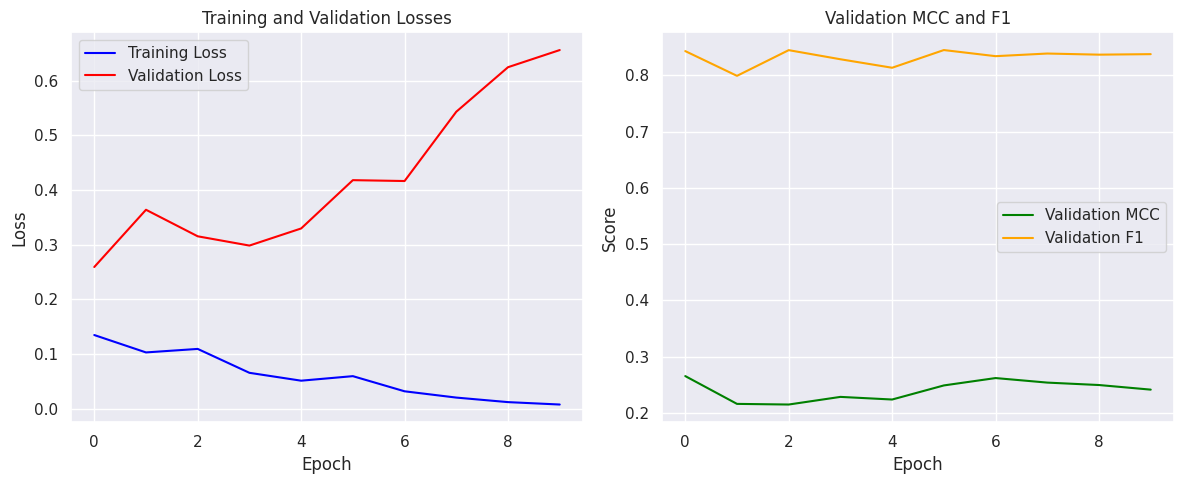

Evaluating on validation set...
Validation MCC: 0.2656
Best model saved with MCC=0.4035 and params={'lr': 0.0001, 'decay': 0.0001, 'batch_size': 128}

=== Final Test Evaluation ===
              precision    recall  f1-score   support

     Class 0       0.24      0.16      0.20       250
     Class 1       0.74      0.83      0.78       733

    accuracy                           0.66       983
   macro avg       0.49      0.50      0.49       983
weighted avg       0.62      0.66      0.63       983


Test MCC: -0.0107
Test F1: 0.7829
Test Accuracy: 0.6582


In [54]:
torch.cuda.empty_cache()
LR_VALUES = [1e-4, 1e-3]
DECAY_VALUES = [0, 1e-4]
BATCH_SIZES = [128]
N_EPOCHS = 10 # количество эпох

ruBert_base_trained_model = training_loop_grid_search_Ru_T5('ai-forever/ruT5-base',train_data, test_data) 

**Общие наблюдения**

1. `ruBERT-base` показал себя лучше по всем ключевым метрикам (Accuracy, F1, MCC), чем `ruT5-base`.

2. Обе модели испытывают сложности с Class 0 (неприемлемые тексты).

3. Отрицательное значение метрики MCC у `ruT5-base` говорит о почти случайном предсказании Class 0.

**Возможные причины худшего качества**

1. Главная причина, полагаю - архитектурные особенности моделей:
   - ruBERT (encoder-only) оптимизирован для классификации, лучше улавливает контекстные зависимости и семантику в тексте;
   - ruT5 (encoder-decoder) заточена на генеративные задачи (суммаризация, перевод). Генерация текстовых меток, а не логитов, очевидно, отличается большей вариабельностью и меньшей предсказуемостью вариабельностью .

2. Возможно, для лучшего качества классификации требуется настройка формата вывода на обучающей выборке с помщью служебного токена <extra_id_0> перед классификационной меткой.

## LogReg Baseline

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from evaluate import load
from tqdm import tqdm

In [79]:
# 1. Подготовка данных
train_df = pd.DataFrame({"sentence": train_data["sentence"], "label": train_data["acceptable"]})
test_df = pd.DataFrame({"sentence": test_data["sentence"],"label": test_data["acceptable"]})

In [80]:
 # Разделение на train/val
X_train, X_val, y_train, y_val = train_test_split(train_df['sentence'],
                                                  train_df['label'],
                                                  test_size=0.2,
                                                  random_state=SEED,
                                                  stratify=train_df['label'])
print(X_train.shape, X_val.shape)

(6295,) (1574,)


In [81]:
# 2. Векторизация текста
vectorizer = TfidfVectorizer(max_features=5000,
                             ngram_range=(1, 2),
                             stop_words=None)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(test_df['sentence'])

In [82]:
mcc_metric = load("matthews_correlation")

In [83]:
def train_logistic_regression(X_train_vec, X_val_vec, X_test_vec,
                              y_train, y_val, test_df,
                              max_iter=1000, random_state=SEED):
    """
    Обучение логистической регрессии с мониторингом метрик
    
    Параметры:
    ...
    max_iter - максимальное число итераций
    random_state - random seed
    """

    # Обучение модели с мониторингом
    model = LogisticRegression(
        max_iter=max_iter,
        class_weight='balanced',
        random_state=random_state,
        warm_start=True  # Для постепенного обучения
    )
    
    # Постепенное обучение
    model.fit(X_train_vec, y_train)

    # Оценка на тесте
    test_preds = model.predict(X_test_vec)
    test_probs = model.predict_proba(X_test_vec)[:, 1]
    
    metrics = {
        'accuracy': accuracy_score(test_df['label'], test_preds),
        'f1': f1_score(test_df['label'], test_preds),
        'mcc': matthews_corrcoef(test_df['label'], test_preds),
        'classification_report': classification_report(
            test_df['label'], test_preds, output_dict=True
        )
    }
    # Вывод результатов
    print("\n=== Результаты на тестовых данных ===")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"MCC: {metrics['mcc']:.4f}\n")
    print("Classification Report:")
    print(classification_report(test_df['label'], test_preds))

    return {
        'model': model,
        'vectorizer': vectorizer,
        'metrics': metrics,
        'predictions': test_preds}

In [84]:
logreg_results = train_logistic_regression(X_train_vec, X_val_vec, X_test_vec, y_train, y_val, test_df)


=== Результаты на тестовых данных ===
Accuracy: 0.6602
F1 Score: 0.7573
MCC: 0.2040

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.51      0.43       250
           1       0.81      0.71      0.76       733

    accuracy                           0.66       983
   macro avg       0.59      0.61      0.60       983
weighted avg       0.70      0.66      0.68       983



**Сравнение моделей для задачи классификации лингвистической приемлемости**

| Модель               | Accuracy | F1 (macro) | MCC   | F1 (Class 0) | F1 (Class 1) | Precision (0) | Recall (0) | Precision (1) | Recall (1) |
|----------------------|----------|------------|-------|--------------|--------------|---------------|-----------|---------------|-----------|
| **Logistic Regression** | 0.6602   | 0.60       | 0.204 | 0.43         | 0.76         | 0.38          | 0.51      | 0.81          | 0.71      |
| **ruBERT-base**        | 0.6907   | 0.52       | 0.061 | 0.24         | 0.81         | 0.32          | 0.19      | 0.76          | 0.86      |
| **ruT5-base**          | 0.6582   | 0.49       | -0.01 | 0.20         | 0.78         | 0.24          | 0.16      | 0.74          | 0.83      |

**Ключевые наблюдения:**

1. `Logistic Regression`:
   - Максимальный MCC (0.204), который наилучшим образом учитывает точность в присутствии дисбаланса классов
   - Лучший F1 для minority-класса (0.43)
   - 
2. **ruBERT-base**:
   - Лучший F1 для majority-класса (0.81).
  
**Возможные причины таких результатов:**

1. **LR не усложняет там, где поверхностных признаков оказывается достаточно**. LR как более простая модель, имеет меньшую "чувствительность", не пытаяется "понять" текст, соответственно наличие в данных редких примеров воспринимает как статистический "шум" (LR явно учитывает частоту встречаемости токенов) и аномалии. За счет этого, LR, видимо, работает с нек. с поверхностными признаками, которых оказыватеся достаточно для верной классификации. "Тяжелые" нейросети, вероятно, излишне усложняют, пытясь анализировать контекст на всех уровнях языка, но данных недостаточно для качественного обучения.

2. **Эффект предобучения ruBERT/ruT5**: ruBERT/ruT5, очевидно, учились на большом массиве грамотных текстов (Wikipedia, news) и не "увидели" достаточно намеренных ошибок (Class 0) при дообучении. Поэтому, предположим, ruBERT/ruT5 фокусируются на корректных языковых паттернах (Class 1), а ошибки интерпретируют как вариации нормы, а не маркеры Class 0

3. **Отсутствие over-smoothing**: нейросети "сглаживают" редкие паттерны через механизмы:
- LayerNorm в ruBERT;
- Teacher Forcing в ruT5;
- LR сохраняет резкие границы между классами при наличии выявленных при обучении ключевых маркеров.

<div style="border: 2px solid #2ca02c; padding: 10px; border-radius: 10px; text-align: center; font-size: 24px; font-weight: bold; color: #2ca02c;">
  RuGPT3_base
</div>

## Zero-shot learning

Модель sberbank-ai/rugpt3large_based_on_gpt2 (как и другие модели на основе GPT-2) не поддерживает системные промпты в том виде, как это делается в более современных моделях, таких как Qwen или GPT-4. GPT-2 и её производные (включая RuGPT-3) не имеют разделения на "системные" и "пользовательские" сообщения. Вместо этого они работают с единым текстовым входом, где контекст и инструкции должны быть явно заданы в одном промпте.

In [9]:
import re
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [10]:
# Загрузка модели и токенизатора
model_name = "sberbank-ai/rugpt3large_based_on_gpt2"  # Модель RuGPT3 base
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/622 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.14G [00:00<?, ?B/s]

In [11]:
model.to(device)  # Перемещаем модель на устройство

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1536)
    (wpe): Embedding(2048, 1536)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=4608, nx=1536)
          (c_proj): Conv1D(nf=1536, nx=1536)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=6144, nx=1536)
          (c_proj): Conv1D(nf=1536, nx=6144)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1536, out_features=50257, bias=False)
)

In [12]:
# Функция для вычисления loss
def get_loss_num(text):
    # Токенизация текста
    inputs = tokenizer(text, return_tensors="pt").to(device)
    # Создание labels для next-token prediction
    labels = inputs["input_ids"].clone()
    # Move labels to the correct device if you're using GPU
    labels = labels.to(device)
    # Вычисление loss
    outputs = model(**inputs, labels=labels)
    loss = outputs.loss

    return loss.item()

In [13]:
def predict_zero_shot(text, acceptable_prompt="Предложение {} не содержит грамматические или смысловые ошибки",
                      unacceptable_prompt="Предложение {} содержит грамматические или смысловые ошибки"):
    # Вычисляем loss для каждого класса
    acceptable_loss = get_loss_num(acceptable_prompt.format(text))
    unacceptable_loss = get_loss_num(unacceptable_prompt.format(text))

    # Возвращаем 1 (приемлемо) или 0 (неприемлемо)
    return 1 if acceptable_loss < unacceptable_loss else 0

### Вспомогательные функции

**Протестируем наши функции на нескольких примерах**

In [18]:
texts = ['Он немедленно не ушел.',
         'Занимаясь определённым делом, оно начинает хорошо получаться.',
         'Хорошо бы он не надел второпях мою шляпу.',
         'Пиво он любит темное.',
         'Мама мыла раму.']

In [19]:
for text in texts:
    print(text + '-> ', predict_zero_shot(text))

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Он немедленно не ушел.->  0
Занимаясь определённым делом, оно начинает хорошо получаться.->  1
Хорошо бы он не надел второпях мою шляпу.->  0
Пиво он любит темное.->  1
Мама мыла раму.->  1


Видим, что даже наш промпт "навскидку" позволи модели правильно классфицировать простые предложения.

---

**Протестируем несколько вариантов промптов, содержащих разные акценты**

In [16]:
acceptable_prompts = [
    "Правильное предложение: {} . все понятно",
    "Это предложение корректно и понятно: {}. Ответ: да, предложение соответствует всем правилам русского языка",
    "Предложение {} не содержит грамматические или смысловые ошибки",
    "Это предложение корректно, естественно и понятно? {} Ответ: да."
]

unacceptable_prompts = [
    "Ошибка: {} сложно понять",
    "Это предложение корректно и понятно: {}. Ответ: нет, предложение не соответствует всем правилам русского языка",
    "Предложение {} содержит грамматические или смысловые ошибки",
    "Это предложение корректно, естественно и понятно? {} Ответ: нет."
]

In [14]:
test_df = test_data.copy(deep=True)
test_df.sample(3)

,id,sentence,acceptable,error_type,detailed_source
810,810,Том и Гек разговаривают.,1,0,Testelets
801,801,Я воздержался от каких бы то ни было комментар...,1,0,Paducheva2013
813,813,"В доме был большой круглый стой, все любили со...",0,Syntax,Testelets


In [17]:
# Результаты
results = []

# Попарный перебор затравок
for acc_prompt, unacc_prompt in zip(acceptable_prompts, unacceptable_prompts):
    # Применяем predict_zero_shot с текущими промптами
    predictions = []
    for sentence in tqdm(test_df["sentence"], desc=f"Промпт: {acc_prompt[:20]}... / {unacc_prompt[:20]}..."):
        pred = predict_zero_shot(sentence, acc_prompt, unacc_prompt)
        predictions.append(pred)
    # Сохраняем результаты
    results.append({
        "acceptable_prompt": acc_prompt,
        "unacceptable_prompt": unacc_prompt,
        "predictions": predictions
    })

Промпт: Правильное предложен... / Ошибка: {} сложно по...:   0%|          | 0/983 [00:00<?, ?it/s]

Промпт: Это предложение корр... / Это предложение корр...:   0%|          | 0/983 [00:00<?, ?it/s]

Промпт: Предложение {} не со... / Предложение {} содер...:   0%|          | 0/983 [00:00<?, ?it/s]

Промпт: Это предложение корр... / Это предложение корр...:   0%|          | 0/983 [00:00<?, ?it/s]

In [18]:
# Вывод отчетов для каждой пары промптов с разделителями
for result in results:
    # Красивый разделитель
    separator = "=" * 80
    print(separator)
    print(f"Промпт: {result['acceptable_prompt']} / {result['unacceptable_prompt']}")
    report = classification_report(test_df["acceptable"], result["predictions"], target_names=["Class 0", "Class 1"])
    print(report)
    # Расчет MCC
    mcc = matthews_corrcoef(test_df["acceptable"], result["predictions"])
    print(f"MCC: {mcc:.4f}\n")

# Финальный разделитель
print("=" * 80)

Промпт: Правильное предложение: {} . все понятно / Ошибка: {} сложно понять
              precision    recall  f1-score   support

     Class 0       0.26      0.61      0.37       250
     Class 1       0.76      0.42      0.54       733

    accuracy                           0.47       983
   macro avg       0.51      0.51      0.46       983
weighted avg       0.63      0.47      0.50       983

MCC: 0.0261

Промпт: Это предложение корректно и понятно: {}. Ответ: да, предложение соответствует всем правилам русского языка / Это предложение корректно и понятно: {}. Ответ: нет, предложение не соответствует всем правилам русского языка
              precision    recall  f1-score   support

     Class 0       0.26      0.77      0.39       250
     Class 1       0.76      0.25      0.38       733

    accuracy                           0.38       983
   macro avg       0.51      0.51      0.38       983
weighted avg       0.64      0.38      0.38       983

MCC: 0.0247

Промпт: Предложе

**Видим, что выбор промптов ("затравок") существенно влияет на качество предсказаний модели**


1. **Промпт:**
   - **Приемлемо:** "Правильное предложение: {} . все понятно"
   - **Неприемлемо:** "Ошибка: {} сложно понять"
   - **Результаты:**
     - **Class 0 (неприемлемо):** Precision = 0.26, Recall = 0.61, F1 = 0.39
     - **Class 1 (приемлемо):** Precision = 0.76, Recall = 0.42, F1 = 0.54
     - **Accuracy:** 0.47

   **Анализ:**
   - Модель сравнительно неплохо справляется с обнаружением неприемлемых предложений (высокий Recall для Class 0), уступая только `LR`, но при этом часто ошибается в предсказании приемлемых (более низкий Recall для Class 1).
   - Низкая точность (Precision) для Class 0 указывает на то, что многие предложения, классифицированные как неприемлемые, на самом деле приемлемы.
   - Общая точность (accuracy) модели низкая (0.47) уступает обученным моделям.

---

2. **Промпт:**
   - **Приемлемо:** "Это предложение корректно и понятно: {}. Ответ: да, предложение соответствует всем правилам русского языка"
   - **Неприемлемо:** "Это предложение корректно и понятно: {}. Ответ: нет, предложение не соответствует всем правилам русского языка"
   - **Результаты:**
     - **Class 0:** Precision = 0.26, Recall = 0.77, F1 = 0.39
     - **Class 1:** Precision = 0.76, Recall = 0.25, F1 = 0.38
     - **Accuracy:** 0.46

   **Анализ:**
   - Recall для Class 0 улучшился;
   - Однако Recall для Class 1 стал ниже.
   - Общая точность примерно та же (0.46).

---

3. **Промпт:**
   - **Приемлемо:** "Предложение {} не содержит грамматические или смысловые ошибки"
   - **Неприемлемо:** "Предложение {} содержит грамматические или смысловые ошибки"
   - **Результаты:**
     - **Class 0:** Precision = 0.22, Recall = 0.34, F1 = 0.27
     - **Class 1:** Precision = 0.73, Recall = 0.60, F1 = 0.65
     - **Accuracy:** 0.53

   **Анализ:**
   - <span style="background-color: #E8F5E9; padding: 2px 4px; border-radius: 4px;">Здесь интересно отметить эффект отрицательной формулировки: использование частицы НЕ существенно изменило "чувствительность" модели к распознованию классов, дало как бы акцент на класссе приемлимых предложений</span>.

---

4. **Промпт:**
   - **Приемлемо:** "Это предложение корректно, естественно и понятно? {} Ответ: да."
   - **Неприемлемо:** "Это предложение корректно, естественно и понятно? {} Ответ: нет."
   - **Результаты:**
     - **Class 0:** Precision = 0.22, Recall = 0.57, F1 = 0.32
     - **Class 1:** Precision = 0.67, Recall = 0.31, F1 = 0.42
     - **Accuracy:** 0.37

   **Анализ:**
   - здесь хужшая точность и отрицательный МСС, то есть модель часто путается в классах.

---

### **Общие выводы:**
1. **Влияние промптов:**
   - Разные промпты приводят к значительным изменениям в метриках.
   - Промпты, которые явно указывают на наличие или отсутствие ошибок, работают лучше, чем более общие формулировки.

2. **Дисбаланс классов:**
   - Модель демонстрирует сильный дисбаланс между Recall для Class 0 и Class 1. Это может быть связано с тем, что модель лучше "понимает" один из классов (например, неприемлемые предложения) и хуже — другой.

3. **Общая точность:**
   - Наилучшая точность достигнута в первых 2-х случаях.


<div style="border: 2px solid #3498DB; padding: 10px; border-radius: 8px; background-color: #F4F6F6; margin: 10px 0;">
  <p style="margin: 0; font-size: 1.1em; color: #2C3E50;">
    <strong>Таким образом, классический файнтюнинг енкодерной модели RuBERT, также LR + TF-IDF </strong> превосходят <strong>Zero-shot промптинг</strong>, несмотря на изощренные "затравки", по всем ключевым метрикам, что особенно важно - в сбалансированности предсказаний для обоих классов. Однако <strong>Zero-shot</strong> подход может быть полезен в случаях, когда важна скорость и отсутствие необходимости в обучении, при условии тщательного подбора промптов.
  </p>
</div>

## Few-shot learning

In [19]:
error_type_frequencies = train_data["error_type"].value_counts()

print("Частоты уникальных значений в столбце 'error_type':")
print(error_type_frequencies)

Частоты уникальных значений в столбце 'error_type':
error_type
0             5864
Syntax        1068
Semantics      805
Morphology     132
Name: count, dtype: int64


Видим, семантические ошибки, среди которых так называемые "галлюцинации", довольно распространены среди других ошибок.

In [20]:
# Настройка отображения DataFrame
pd.set_option('display.max_colwidth', None)  # Отключаем ограничение на длину текста в столбцах
pd.set_option('display.max_columns', None)  # Отображаем все столбцы
pd.set_option('display.width', None)  # Отключаем перенос строк


In [21]:
# Группируем по error_type и выбираем по 5 случайных примеров для каждого типа
sampled_examples = train_data.groupby("error_type").apply(lambda x: x.sample(min(len(x), 5), random_state=30))
# Сбрасываем индекс для удобства
sampled_examples = sampled_examples.reset_index(drop=True)
# Выводим результат
for error_type, group in sampled_examples.groupby("error_type"):
    print(f"Примеры для error_type: {error_type}")
    print(group[["sentence", "error_type"]])
    print("\n" + "=" * 80 + "\n")

Примеры для error_type: 0
                                                                                                                                                                     sentence  \
0                                                                                                                                               Мой дядя восходил на Эверест.   
1                                                                                                                       Из-за раскрывшихся губ показался ряд блестящих зубов.   
2  Как всегда, Блока пленили, казалось бы, случайные и даже посторонние черты пейзажа, которые он был мастер подмечать и которые приобретали для него особую выразительность.   
3                                                                                                                           Протянешь руку в последний момент ― а там никого.   
4                                                                                        

**Исходя из 2-х наиболее распространенных ошибок, постараемся учесть их в положительных отрицательных примерах.**

### Вспомогательные функции

In [24]:
# Функция для создания Few-shot промпта
def create_few_shot_prompt(text, shot_examples):
    # Добавляем примеры для приемлемых предложений
    prompt_acceptable = ' '.join(shot_examples) + f" Это предложение корректно, естественно и понятно? {text} Ответ: да."
    prompt_unacceptable = ' '.join(shot_examples) + f" Это предложение корректно, естественно и понятно? {text} Ответ: нет."

    return prompt_acceptable, prompt_unacceptable

In [25]:
# Функция для Few-shot предсказания
def predict_few_shot(text, shot_examples):
    # Создаём Few-shot промпты
    acceptable_prompt, unacceptable_prompt = create_few_shot_prompt(
        text, shot_examples)

    acceptable_loss = get_loss_num(acceptable_prompt)
    unacceptable_loss = get_loss_num(unacceptable_prompt)

    return 1 if acceptable_loss < unacceptable_loss else 0

In [26]:
texts = ['Он немедленно не ушел.',
         'Занимаясь определённым делом, оно начинает хорошо получаться.',
         'Хорошо бы он не надел второпях мою шляпу.',
         'Пиво он любит темное.',
         'Мама мыла раму.']

In [28]:
for text in texts:
    print(text + '-> ', predict_few_shot(text, few_shot_examples))

Он немедленно не ушел.->  0
Занимаясь определённым делом, оно начинает хорошо получаться.->  1
Хорошо бы он не надел второпях мою шляпу.->  1
Пиво он любит темное.->  1
Мама мыла раму.->  1


### One-shot

In [42]:
# Примеры для Few-shot обучения
one_shot_examples = [
    "Это предложение корректно, естественно и понятно: " + "Я пошёл в магазин купить хлеб." + " Ответ: да.",
    "Это предложение корректно, естественно и понятно: " + "Я пойти магазин купить хлеб." + " Ответ: нет.",
    "Это предложение корректно, естественно и понятно: " + "Она достает шнур с блендером и аккуратно вытягивает из лезвия арахис." + " Ответ: нет.",
    "Это предложение корректно, естественно и понятно: " + "Сериал продлен на 3 и 4 сезоны 22.02." + " Ответ: нет.",
    "Это предложение корректно, естественно и понятно: " + '''Неизвестный серийный убийца, подозреваемый в убийстве по меньшей мере пятнадцати женщин в Атланте в 1911 году,
    когда произошли и другие не менее страшные события.''' + " Ответ: да.",
    "Это предложение корректно, естественно и понятно: " + "Она достать шнуры с блендерами и аккуратно вытягивает из лезвия арахис, которого." + " Ответ: нет.",

]

In [43]:
results = []

for shot_example in one_shot_examples:
    # Применяем predict_few_shot с текущими промптами
    predictions = []
    for sentence in tqdm(test_df["sentence"], desc=f"SHOT: {shot_example[:90]}"):
        pred = predict_few_shot(sentence, shot_example)
        predictions.append(pred)

    # Сохраняем результаты
    results.append({
        "shot_example": shot_example,
        "predictions": predictions
    })

# Вывод отчетов для каждой пары промптов с разделителями
for result in results:
    # Красивый разделитель
    separator = "=" * 80
    print(separator)
    print(f"Промпт: {result['shot_example']}")
    report = classification_report(test_df["acceptable"], result["predictions"], target_names=["Class 0", "Class 1"])
    print(report)
    # Расчет MCC
    mcc = matthews_corrcoef(test_df["acceptable"], result["predictions"])
    print(f"MCC: {mcc:.4f}\n")

# Финальный разделитель
print("=" * 80)

SHOT: Это предложение корректно, естественно и понятно: Я пошёл в магазин купить хлеб. Ответ: да:   0%|       …

SHOT: Это предложение корректно, естественно и понятно: Я пойти магазин купить хлеб. Ответ: нет.:   0%|       …

SHOT: Это предложение корректно, естественно и понятно: Она достает шнур с блендером и аккуратно:   0%|       …

SHOT: Это предложение корректно, естественно и понятно: Сериал продлен на 3 и 4 сезоны 22.02. От:   0%|       …

SHOT: Это предложение корректно, естественно и понятно: Неизвестный серийный убийца, подозреваем:   0%|       …

SHOT: Это предложение корректно, естественно и понятно: Она достать шнуры с блендерами и аккурат:   0%|       …

Промпт: Это предложение корректно, естественно и понятно: Я пошёл в магазин купить хлеб. Ответ: да.
              precision    recall  f1-score   support

     Class 0       0.21      0.22      0.22       250
     Class 1       0.73      0.72      0.73       733

    accuracy                           0.59       983
   macro avg       0.47      0.47      0.47       983
weighted avg       0.60      0.59      0.60       983

MCC: -0.0549

Промпт: Это предложение корректно, естественно и понятно: Я пойти магазин купить хлеб. Ответ: нет.
              precision    recall  f1-score   support

     Class 0       0.24      0.74      0.37       250
     Class 1       0.70      0.20      0.32       733

    accuracy                           0.34       983
   macro avg       0.47      0.47      0.34       983
weighted avg       0.58      0.34      0.33       983

MCC: -0.0542

Промпт: Это предложение корректно, естественно и понятно: Она достает шнур с блендером и аккуратно вытягивает из лезвия

**Видим:**

1. Лучшие метрики для One-shot:

- Accuracy:	0.59 > 0.53	(Zero-shot, the best one),
- F1 Class1: 0.73 >	0.65 (Zero-shot, the best one),
- F1 Class0: 0.37 <	0.39 (Zero-shot, the best one),
- MCC:	-0.044 < 0.0261 (Zero-shot, the best one).

2. Вариабельность отрицательных и положительных примеров при данном промпте не дала существенного прироста, а, скорее, поспособствовала менее "уверенному поведению" модели, что отражает низкое значение MCC.

### Two-shots

**При тестировании 2-х примеров скомбинируем их в группы**:

1) простые положительные и отрицательные примеры с разными "затравками";
2) более сложные промпты с "затравками", ставящими (с чел точки зрения) бОльший акцент на семантике + семантически некорректными примерами;
3) составной сложный промпт, содержащие разные типы ошибок.

In [39]:
# Заранее заданные пары примеров для Few-shot обучения
few_shot_examples = [
    [
        "Это предложение корректно, естественно и понятно? " + "Я пошёл в магазин купить хлеб." + " Ответ: да.",
        "Это предложение корректно, естественно и понятно? " + "Я пойти магазин купить хлеб." + " Ответ: нет."
    ],
    [
        "Правильное предложение: " + "Я пошёл в магазин купить хлеб." + " Все понятно.",
        "Ошибка: " + "Я пойти магазин купить хлеб." + " Предложение сложно понять."
    ],
    [
        "Это предложение естественно и понятно? " + "Она достает шнур с блендером и аккуратно вытягивает из лезвия арахис." + " Ответ: нет.",
        "Это предложение естественно и понятно? " + "Сериал продлен на 3 и 4 сезоны 22.02." + " Ответ: нет."
    ],
    [
        "Это предложение корректно, естественно и понятно? " + '''Неизвестный серийный убийца, подозреваемый в убийстве по меньшей мере пятнадцати женщин в Атланте в 1911 году,
        когда произошли и другие не менее страшные события.''' + " Ответ: да.",
        "Это предложение корректно, естественно и понятно? " + "Она достать шнуры с блендерами и аккуратно вытягивает из лезвия арахис, которого." + " Ответ: нет."
    ]
    
]
# Результаты

In [40]:
# Функция для выполнения Few-shot обучения и вывода отчетов
def run_few_shot_learning(test_df, grouped_shot_examples):
    results = []
    # Выполняем Few-shot обучение для каждой группы
    for group in grouped_shot_examples:
        predictions = []
        for sentence in tqdm(test_df["sentence"], desc=f"SHOT: {group}"):
            pred = predict_few_shot(sentence, group)
            predictions.append(pred)

        # Сохраняем результаты
        results.append({
            "shot_example": group,
            "predictions": predictions
        })
    # Вывод отчетов для каждой пары промптов
    for result in results:
        separator = "=" * 80
        print(separator)
        print(f"Промпты: {result['shot_example']}")
        report = classification_report(test_df["acceptable"], result["predictions"], target_names=["Class 0", "Class 1"])
        print(report)
        # Расчет MCC
        mcc = matthews_corrcoef(test_df["acceptable"], result["predictions"])
        print(f"MCC: {mcc:.4f}\n")
    # Финальный разделитель
    print("=" * 80)

In [41]:
run_few_shot_learning(test_df, few_shot_examples)

SHOT: ['Это предложение корректно, естественно и понятно? Я пошёл в магазин купить хлеб. Ответ: да.', 'Это пре…

SHOT: ['Правильное предложение: Я пошёл в магазин купить хлеб. Все понятно.', 'Ошибка: Я пойти магазин купить …

SHOT: ['Это предложение естественно и понятно? Она достает шнур с блендером и аккуратно вытягивает из лезвия а…

SHOT: ['Это предложение корректно, естественно и понятно? Неизвестный серийный убийца, подозреваемый в убийств…

Промпты: ['Это предложение корректно, естественно и понятно? Я пошёл в магазин купить хлеб. Ответ: да.', 'Это предложение корректно, естественно и понятно? Я пойти магазин купить хлеб. Ответ: нет.']
              precision    recall  f1-score   support

     Class 0       0.17      0.11      0.14       250
     Class 1       0.73      0.81      0.77       733

    accuracy                           0.64       983
   macro avg       0.45      0.46      0.45       983
weighted avg       0.59      0.64      0.61       983

MCC: -0.0859

Промпты: ['Правильное предложение: Я пошёл в магазин купить хлеб. Все понятно.', 'Ошибка: Я пойти магазин купить хлеб. Предложение сложно понять.']
              precision    recall  f1-score   support

     Class 0       0.22      0.16      0.18       250
     Class 1       0.74      0.81      0.77       733

    accuracy                           0.64       983
   macro avg       0.48      0.48      0.48       983
weighted avg       0.61      0.64      0

**Видим**

1. Лучшие метрики для 2-shot по сравнению с 0/1-shot:

- Accuracy:	0.64,
- F1 Class1: 0.77,

При этом лучшая F1 Class0: 0.18,что значительно хуже 0/1-shots,также незначительно ухудшилось значение MCC. Интересно, что качество предсказаний приблизилось к нейросетям.

2. Предложение с 2-мя отрицательными примерами как бы настраивает модель отдавать предпочтение Class 0
3. Сложный и составной пример не дает значимого эффекта.

**При создании набора из 4-х примеров**:
- будем использовать более простые варианты промптов,
- устраним наличие семантически подобных, но синтаксически некорректных примеров в одном наборе, возможно модель воспринимате их как близкие, а неправильности "воспринимает" как несущественный "шум";
- модель, как правило, сильнее реагирует на последний пример в промпте: учтем это.

### Four-shots

In [55]:
# Заранее заданные пары примеров для Few-shot обучения
few_shot_4_examples = [
    [
        "Это предложение понятно и правильно? " + "Я пошёл в магазин купить хлеб." + " Ответ: да.",
        "Это предложение понятно и правильно? " + "Он немедленно не ушел." + " Ответ: нет.",
        "Это предложение понятно и правильно? " + "Сильный прибой и каменистый берег сделали пляж непригодным для купания" + " Ответ: да.",
        "Это предложение понятно и правильно? " + "Отец часто говорил, что очень любит шахматные соревнования и ловить рыбу" + " Ответ: нет."
    ]
]

In [56]:
run_few_shot_learning(test_df, few_shot_4_examples)

SHOT: ['Это предложение понятно и правильно? Я пошёл в магазин купить хлеб. Ответ: да.', 'Это предложение поня…

Промпты: ['Это предложение понятно и правильно? Я пошёл в магазин купить хлеб. Ответ: да.', 'Это предложение понятно и правильно? Он немедленно не ушел. Ответ: нет.', 'Это предложение понятно и правильно? Сильный прибой и каменистый берег сделали пляж непригодным для купания Ответ: да.', 'Это предложение понятно и правильно? Отец часто говорил, что очень любит шахматные соревнования и ловить рыбу Ответ: нет.']
              precision    recall  f1-score   support

     Class 0       0.19      0.18      0.19       250
     Class 1       0.72      0.73      0.73       733

    accuracy                           0.59       983
   macro avg       0.46      0.46      0.46       983
weighted avg       0.59      0.59      0.59       983

MCC: -0.0893



In [57]:
# Заранее заданные пары примеров для Few-shot обучения
few_shot_4_examples_2 = [
    [
        "Это предложение корректно, естественно и понятно? " + "Раз мы затронули тему коррупции, есть ли, на ваш взгляд, свет в конце тоннеля?" + " Ответ: да.",
        # error type: Semantics
        "Это предложение корректно, естественно и понятно? " + "У меня мама на пенсии, а у Нины она работает."  + " Ответ: нет.",
        "Это предложение корректно, естественно и понятно? " + "Сильный прибой и каменистый берег сделали пляж непригодным для купания." + " Ответ: да.",
        # error type: Syntax
        "Это предложение корректно, естественно и понятно? " + "Отец часто говорил, что очень любит шахматные соревнования и ловить рыбу." + " Ответ: нет.",
    ]
]

In [48]:
run_few_shot_learning(test_df, few_shot_4_examples_2)

SHOT: ['Это предложение корректно, естественно и понятно? Раз мы затронули тему коррупции, есть ли, на ваш взг…

Промпты: ['Это предложение корректно, естественно и понятно? Раз мы затронули тему коррупции, есть ли, на ваш взгляд, свет в конце тоннеля? Ответ: да.', 'Это предложение корректно, естественно и понятно? У меня мама на пенсии, а у Нины она работает. Ответ: нет.', 'Это предложение корректно, естественно и понятно? Сильный прибой и каменистый берег сделали пляж непригодным для купания. Ответ: да.', 'Это предложение корректно, естественно и понятно? Отец часто говорил, что очень любит шахматные соревнования и ловить рыбу. Ответ: нет.']
              precision    recall  f1-score   support

     Class 0       0.24      0.67      0.35       250
     Class 1       0.70      0.27      0.39       733

    accuracy                           0.37       983
   macro avg       0.47      0.47      0.37       983
weighted avg       0.58      0.37      0.38       983

MCC: -0.0624



In [58]:
run_few_shot_learning(test_df, few_shot_4_examples_2)

SHOT: ['Это предложение корректно, естественно и понятно? Раз мы затронули тему коррупции, есть ли, на ваш взг…

Промпты: ['Это предложение корректно, естественно и понятно? Раз мы затронули тему коррупции, есть ли, на ваш взгляд, свет в конце тоннеля? Ответ: да.', 'Это предложение корректно, естественно и понятно? У меня мама на пенсии, а у Нины она работает. Ответ: нет.', 'Это предложение корректно, естественно и понятно? Мама мыла раму. Ответ: да.', 'Это предложение корректно, естественно и понятно? Отец часто говорил, что очень любит шахматные соревнования и ловить рыбу. Ответ: нет.']
              precision    recall  f1-score   support

     Class 0       0.23      0.69      0.35       250
     Class 1       0.68      0.23      0.34       733

    accuracy                           0.35       983
   macro avg       0.46      0.46      0.35       983
weighted avg       0.57      0.35      0.34       983

MCC: -0.0808



Итак, очевидно, что с ростом числа примеров, несмотря на предпринятые ухищрения, качество существенно не растет. Набор разных по типу ошибок примеров существенно влияет на итоговое качество, а также на "предпочтения" модели классифицировать примеры как положительные или отрицательные.

---

**Полагаю, наилучшей стратегией является проработка и использование "правильных" промптов для Zero-shot-learning. Few-shots следует использовать, если есть задача классифицировать определенные типы ошибок, при этом целесообразно ограничиться 1,2 примерами.** 